# Task 1. Fully-connected networks. Pytorch. (10 pts)

<span style="color:red">__All cells of the notebook should work without errors when run consecutively.__</span>

Before starting the assignment, make this notebook `Trusted` for valid display of images:

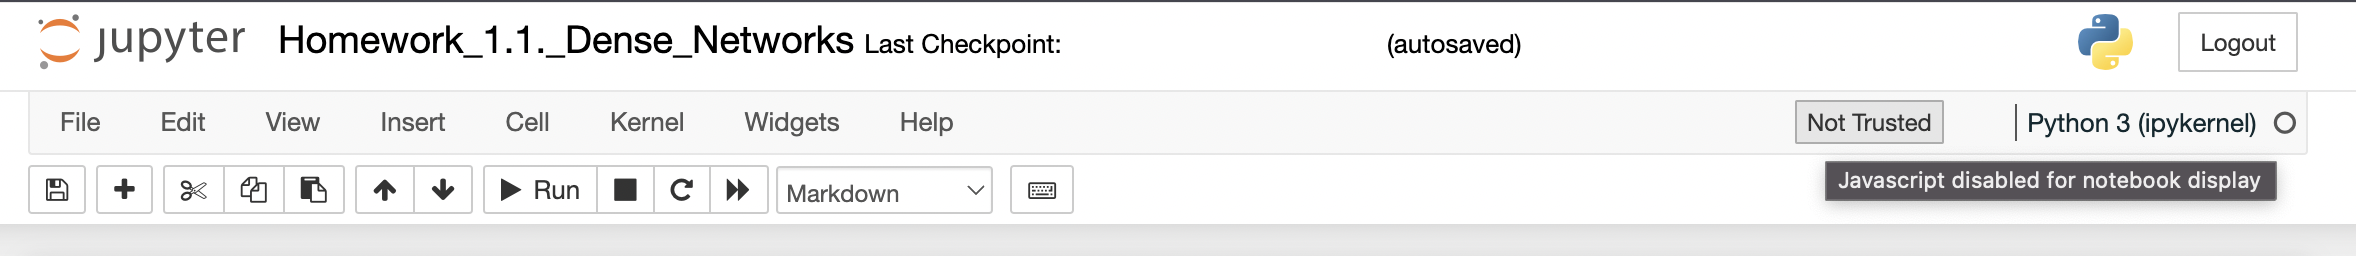

### Implementing a neural network

In this task, you will train a fully connected neural network to classify handwritten numbers by implementing all components of the algorithm for learning and predicting.

To implement the model, we will use the **Pytorch** framework. The standard approach to implementing neural network models is its decomposition into separate blocks. Using this library, you can create both models from ready-made layer blocks and implement your own modules. At the same time, Pytorch hides all the complexity associated with calculating model outputs from its inputs and calculating gradients, which makes this library especially convenient when using *Gradient optimization methods*, such as **Stochastic Gradient Descent (SGD)** and others.

In [1]:
import numpy as np
import torch


In order to implement your custom block, you need to inherit it from the base class for all neural networks `torch.nn.Module`.

Then, for convenience and in accordance with common practice, the module should implement the `forward` function. This function usually implements the main calculation logic of the module, the so-called *forward pass* through the layer. Pytorch uses the `forward` function to override the `__call__` magic method, allowing the following syntactic sugar to be used to calculate the forward pass:
```python
# Two equivalent ways to do a forward pass through a block:
out = module(x)
out = module.forward(x)
```

It should be noted that blocks are just a convenient wrapper for calculations and creating an automatic differentiation graph.

Let's consider the simplest example of a module that implements **Identity transform**:

In [2]:
class Identity(torch.nn.Module):
    def __init__(self):
        """
        Block constructor. Here we usually create trainable parameters and save variables,
             defining the global state of the layer, as well as its hyperparameters
        A block can contain subblocks, which were also inherited from the base class torch.nn.Module
        """
        # It is necessary to call the base class constructor for the block to work correctly
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        A function that implements a forward pass through a layer. During the computations, a computation graph
             is created. We will perform the automatic differentiation through it later.
             through which automatic differentiation is performed.
        """
        return x

    def __repr__(self):
        """
        It is good practice to override the string representation for blocks
        Usually, in addition to the class name, the hyperparameters of this class are also displayed
        """
        return "Identity()"


Let's create an instance of this layer and check its operation:

In [3]:
identity_layer = Identity()
x = torch.randn([3, 5])

# Please note that the __call__ method was automatically overridden by calling the forward method
print(x, identity_layer(x), sep="\n")
print(identity_layer, torch.equal(x, identity_layer(x)))


tensor([[ 0.8463,  1.4668, -0.1253,  0.4191,  0.9203],
        [-1.4742,  0.2931, -0.3641, -0.3580,  0.7680],
        [-0.4636,  0.7146,  1.1264,  0.1512, -0.8196]])
tensor([[ 0.8463,  1.4668, -0.1253,  0.4191,  0.9203],
        [-1.4742,  0.2931, -0.3641, -0.3580,  0.7680],
        [-0.4636,  0.7146,  1.1264,  0.1512, -0.8196]])
Identity() True


### ReLU non-linearity layer

Now we implement a non-linearity layer $\text{ReLU}(y) = \max(0, y)$. The layer has no parameters. The `forward` method should return the result of applying $\text{ReLU}$ element-wise to the input array.

In [4]:
class ReLU(torch.nn.Module):
    def __init__(self):
        """
        The ReLU layer applies a rectified linear unit to each element of the input
        """
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply ReLU to the input tensor
        """
        return torch.maximum(torch.zeros_like(x), x)


In [5]:
relu_layer = ReLU()
x = torch.randn([3, 5])

assert not torch.any(relu_layer(x) < 0)
assert torch.all(torch.eq(relu_layer(x), torch.nn.ReLU()(x)))

print(x, relu_layer(x), sep="\n")
print(relu_layer)


tensor([[-2.1471, -0.3562,  1.7013, -0.5579, -0.8476],
        [-1.0294,  0.8349, -1.4584, -1.6513,  0.9208],
        [-0.9038, -0.7177,  0.6645, -0.6298,  1.3762]])
tensor([[0.0000, 0.0000, 1.7013, 0.0000, 0.0000],
        [0.0000, 0.8349, 0.0000, 0.0000, 0.9208],
        [0.0000, 0.0000, 0.6645, 0.0000, 1.3762]])
ReLU()


### Linear (fully-connected) layer

Next, we will implement a fully connected layer `Linear` without non-linearity. The layer has two parameters: **weight matrix** and **bias vector**.

The main advantage of the base class `torch.nn.Module` is the presence of an interface for working with parameters (trainable weights of the model), buffers (untrainable tensors of the model) and submodules (that is, other modules that are inherited from `torch.nn.Module`, which create a hierarchical structure of the model).

If parameters/buffers/submodules are registered in a module, then the base class allows you to work with these entities. Let's look at the main methods:
* `parameters` - returns an iterator over all parameters registered in this module and all its submodules
* `named_parameters` - returns an iterator over all parameters and their names registered in this module and all its submodules
* `buffers`/`named_buffers` - similar functions for accessing a list of all buffers
* `requires_grad_(requires_grad=True)` - in-place method that turns on or off the calculation of gradients for the parameters
* `to(device, dtype)` - changing the type of parameters and the device on which they are located
* `train`/`eval` - recursive switching of module operation modes. Usually, before training the network, you need to call the `train` method, and before testing (inference) you need to switch it to the `eval` mode. These methods are necessary for the correct implementation of such regularization methods as BatchNorm and Dropout

A detailed description of these and other available methods can be found in [docs](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Now let's look at the process of registering parameters/buffers/submodules.
There are two main registration options:
1. **Implicit registration**. It occurs at the moment of creating a class attribute and assigning it a wrapper class `torch.nn.Parameter` (for registering parameters) or a child class of `torch.nn.Module` (for registering submodules). Please note that **assigning a tensor does not register a parameter**. Also, it's worth noting that there is no implicit way to register buffers.
2. **Explicit registration** using the `register_parameter, register_buffer, register_module` methods.

By default, when writing your code, you should give preference to *implicit registration*.

Let us separately highlight a common situation in which it is necessary to register a variable (or simply a sufficiently large) number of parameters/submodules. Indeed, in modern models there can be tens and hundreds of layers and thousands of tensor parameters, which are logically stored in the model not in the form of individual attributes, but in the form of a list or a dictionary. However, by storing parameters/submodules in such a data structure, **implicit registration will not automatically work**. To get around this drawback, **PyTorch** has implemented a set of containers that, when parameters are added to them, will register them in the current block. For example, a container for a list of parameters `torch.nn.ParameterList` and a container for a dictionary of parameters `torch.nn.ParameterDict` are available. Similar [container classes](https://pytorch.org/docs/stable/nn.html#containers) are also available for modules: `torch.nn.ModuleList`, `torch.nn.ModuleDict`. When implementing layers with a fixed number of parameters (for example, `Linear`), such classes are usually not needed.

Let us immediately pay attention to a particularly important point when working with trainable parameters. The quality of the final model and the training process can significantly depend on the initialization of parameters. Therefore, **it is necessary to carefully control the initialization**. In **Pytorch**, a common way to reset a block is to implement a `reset_parameters` method, which properly initializes the trainable weights, clears the buffers, and so on.

Implement a linear layer block in the cell below.

**Do not use ready-made linear layer implementations (from `torch.nn` and other modules) in this task.**

In [6]:
class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        """
        A fully-connected layer performs affine transform f(x) = x W + b
        """
        super().__init__()

        # Create neccessary trainable parameters
        self.weight = torch.nn.Parameter(
            torch.randn([in_features, out_features]) * 0.01
        )
        self.bias = torch.nn.Parameter(torch.zeros([out_features]))

        # Initialize the weights
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initializing the weights of a fully-connected layer from the normal distribution with
             zero mean and standard deviation equal to 0.01
        The bias vector is initialized with zeros
        """
        torch.nn.init.normal_(self.weight, mean=0, std=0.01)
        torch.nn.init.zeros_(self.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute affine transform f(x) = x W + b

        :param torch.Tensor x: input matrix of size [batch_size, in_features]
        :returns: matrix of size [batch_size, out_features]
        """
        return x @ self.weight + self.bias

    def __repr__(self):
        """
        Optional method for pretty print
        """
        return f"Linear(in_features={self.weight.shape[0]}, out_features={self.weight.shape[1]})"


In [7]:
linear_layer = Linear(3, 5)
x = torch.randn([2, 3])

print(x, linear_layer(x), sep="\n")
print(linear_layer)


tensor([[ 0.5897, -0.2895, -1.3816],
        [ 0.8054,  0.2162, -0.3670]])
tensor([[ 0.0162,  0.0269, -0.0146,  0.0125,  0.0092],
        [ 0.0125,  0.0130, -0.0030,  0.0016,  0.0014]], grad_fn=<AddBackward0>)
Linear(in_features=3, out_features=5)


Children blocks of `torch.nn.Module` automatically save information about their structure: parameters, buffers. For example, you can get a generator of all parameters in a given block (the `parameters` method). Moreover, each parameter has its own unique name (usually it matches the name of the variable to which the corresponding parameter was assigned). A named list of parameters can be obtained by calling the `named_parameters` method:

In [8]:
linear_layer, list(linear_layer.parameters()), list(linear_layer.named_parameters())


(Linear(in_features=3, out_features=5),
 [Parameter containing:
  tensor([[ 0.0061,  0.0118,  0.0002,  0.0011, -0.0087],
          [ 0.0144, -0.0062,  0.0024, -0.0081,  0.0155],
          [-0.0121, -0.0132,  0.0102, -0.0069, -0.0136]], requires_grad=True),
  Parameter containing:
  tensor([0., 0., 0., 0., 0.], requires_grad=True)],
 [('weight',
   Parameter containing:
   tensor([[ 0.0061,  0.0118,  0.0002,  0.0011, -0.0087],
           [ 0.0144, -0.0062,  0.0024, -0.0081,  0.0155],
           [-0.0121, -0.0132,  0.0102, -0.0069, -0.0136]], requires_grad=True)),
  ('bias',
   Parameter containing:
   tensor([0., 0., 0., 0., 0.], requires_grad=True))])

### Implementing Softmax layer and loss function

To solve a multi-class classification problem, it is common to use $Softmax$ as the non-linearity at the last layer to obtain the class probabilities for each object:
$$\hat y = \text{Softmax}(x) = \left \{\frac {\exp(x^i)}{\sum_{j=1}^K \exp(x^j)} \right \}_{i=1}^K, \quad K - \text{number of classes.}$$

Here, by $x^i$ we denote the $i$-th attribute of the object $x$.

As a loss function, we will choose the negative log likelihood (NLL)
$$L(y, \hat y) = -\sum_{i=1}^K \mathbb{1}[y = i]\log \hat y^i,$$
where $\mathbb{1}[y = i]$ is an indicator that the ground truth target $y$ is equal to class $i$.

NLL coincides with the expression for [cross-entropy](https://ru.wikipedia.org/wiki/Cross_entropy) (we take the degenerate distribution at point $y$ as the first distribution, and the predicted distribution $\hat y$ as the second). Obviously, this loss function can also be rewritten through indexing, if $y$ denotes the class of a given object:
$$L(y, \hat y) = - \log \hat y_{y}$$

It is convenient to implement it in this form.

To train a neural network, we will optimize this loss function with respect to the parameters of the neural network:

$$ \mathfrak{L} = \frac1N \sum_{i=1}^N L(y_i, \hat y_i) = \frac1N \sum_{i=1}^N L(y_i, \text{NN}_{\theta }(x_i)) \rightarrow \min_{\theta}\,,$$
where by $x_i$ and $y_i$ we denote the features and the target of the $i$-th object of the training sample, by $\text{NN}_{\theta}$ we denote the neural network, which takes the features of the object $x_i$ as an input and outputs class probabilities $\hat y_i$, $\theta$ denotes all the weights of the neural network, and $N$ is the number of objects in the training set.

Implement the loss function `CrossEntropyLoss`. Loss functions sometimes inherit from the `torch.nn.Module` base class, but often the layer itself is not included in the neural network. When calculating `CrossEntropyLoss`, take the average (and not the sum) of the loss function values over the batch. This is usually done so that during two runs of training a neural network with different batch sizes, the resulting loss function values for these networks are comparable.

Implement a block to calculate cross-entropy in the cell below.

When calculating logsoftmax, it is necessary to use numerically stable methods. In particular, use the [Exp-Normalize Trick](https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/) when implementing this feature.

**Do not use ready-made cross-entropy implementations (from `torch.nn` and other modules) in this task.**

In [9]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Apply logsoftmax to each row and select a correct element from each row
             according to the ground truth labels
        :param torch.Tensor x: logit matrix of size [batch_size, n_classes]
        :param torch.Tensor labels: array of ground truth labels of size [batch_size]
        :returns: Cross-entropy loss function value
        """
        max_vals, _ = torch.max(x, dim=1, keepdim=True)
        shifted_logits = x - max_vals
        exp_shifted = torch.exp(shifted_logits)
        log_softmax = shifted_logits - torch.log(
            torch.sum(exp_shifted, dim=1, keepdim=True)
        )
        return -log_softmax[torch.arange(labels.size(0)), labels].mean()


In [10]:
torch_cel = torch.nn.CrossEntropyLoss()
cel_layer = CrossEntropyLoss()
x = torch.randn([101, 51], requires_grad=True)
labels = torch.randint(0, x.shape[1], size=[x.shape[0]])

assert torch.abs(cel_layer(x, labels) - torch.nn.CrossEntropyLoss()(x, labels)) < 1e-6


torch_loss = torch_cel(x, labels)
torch_loss.backward()
torch_grad = x.grad
x.grad.zero_()

custom_loss = cel_layer(x, labels)
custom_loss.backward()
custom_grad = x.grad
x.grad.zero_()

assert torch.allclose(custom_grad, torch_grad, atol=1e-6), "Gradients don't match"

print(cel_layer, cel_layer(x, labels))


CrossEntropyLoss() tensor(4.4669, grad_fn=<NegBackward0>)


## Constructing Neural Network

To create models from a set of layers in **Pytorch** the following hierarchical approach is typically used. Each block inherited from `torch.nn.Module` may contain other layers also inherited from `torch.nn.Module`. As described earlier, submodules/parameters/buffers have two ways of registering - implicit (via assigning a class attribute) and explicit (in the case of modules, via the `register_module` method).

To solve the problem of registering module lists/dictionaries, **Pytorch** implements containers with auto-registration support. As with parameters, there are several such containers:
* `torch.nn.ModuleList` - stores a list of modules
* `torch.nn.ModuleDict` - stores a dictionary of modules
* `torch.nn.Sequential` - a special container that stores a list of modules and allows you to sequentially apply modules from the list to the object given as input

Implement the simplest fully-connected neural network `DenseNetwork`.

Implement the following network hyperparameters:
- width (the size of hidden layers `hidden_size`)
- depth (the number of layers `n_layers`)
- size of input `in_features` and output `n_classes`
- activation function `activation` between linear layers

Don't include a loss function into a neural network.

To store the modules, you can use any of the containers of your choice.

In [11]:
class DenseNetwork(torch.nn.Module):
    def __init__(self, in_features, hidden_size, n_classes, n_layers, activation=ReLU):
        """
        :param int in_features: Number of input features
        :param int hidden_size: Hidden layer size
        :param int n_classes: Number of outputs
        :param int n_layers: Number of layers in the network
        :param torch.nn.Module activation: Activation function class
        """
        super().__init__()

        self.layers = torch.nn.ModuleList([Linear(in_features, hidden_size)])
        for _ in range(n_layers - 2):
            self.layers.append(Linear(hidden_size, hidden_size))
        self.layers.append(Linear(hidden_size, n_classes))
        self.activation = activation()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the networks
        :param torch.Tensor x: Input tensor of size [batch_size, in_features]
        :returns: Logit matrix of size [batch_size, n_classes]
        """
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i != len(self.layers) - 1:
                x = self.activation(x)
        return x


Check that your implementation passes the minimum tests:

In [12]:
assert sum(buffer.numel() for buffer in DenseNetwork(11, 7, 5, 3).buffers()) == 0
assert sum(param.numel() for param in DenseNetwork(64, 32, 10, 3).parameters()) == 3466

assert list(DenseNetwork(64, 32, 10, 3)(torch.randn([13, 64])).shape) == [13, 10]


In [13]:
in_features = np.prod(8 * 8 * 1)
hidden_size = 32
n_classes = 10

dense_network = DenseNetwork(
    in_features=in_features,
    hidden_size=hidden_size,
    n_classes=n_classes,
    n_layers=3,
    activation=ReLU,
)
x = torch.randn([5, in_features])
print(dense_network(x))
print(dense_network)


tensor([[ 2.4739e-06,  7.1694e-05,  2.6175e-05, -5.5795e-05,  2.6910e-05,
          4.0981e-05,  5.5952e-05,  4.6332e-05, -6.5432e-05,  2.4501e-05],
        [-5.6137e-05, -7.4770e-05,  4.2962e-05, -1.6759e-04,  8.5810e-07,
          5.4790e-05, -6.4817e-05,  9.2230e-05, -1.7175e-04,  1.9805e-04],
        [-7.5566e-05,  1.4351e-04, -8.8169e-05,  2.3213e-05,  5.9230e-05,
          3.2381e-05,  1.5415e-04,  3.3626e-05, -2.6845e-04, -4.2456e-05],
        [-9.7861e-05, -3.6092e-05, -1.6598e-04, -4.4896e-05,  5.4113e-05,
          2.2089e-04,  1.4286e-04,  3.0937e-05, -2.7470e-04,  8.1933e-05],
        [-1.3358e-04, -1.2762e-04, -7.3841e-06, -4.8820e-05, -1.4865e-04,
          3.7363e-05,  9.0959e-05,  5.4727e-06, -1.0844e-04,  2.2135e-04]],
       grad_fn=<AddBackward0>)
DenseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=32)
    (1): Linear(in_features=32, out_features=32)
    (2): Linear(in_features=32, out_features=10)
  )
  (activation): ReLU()
)


Note that you can get a list of all network parameters because of automatical modules registering:

In [14]:
list(dense_network.parameters())


[Parameter containing:
 tensor([[-0.0117, -0.0182, -0.0086,  ..., -0.0294, -0.0139, -0.0179],
         [ 0.0015, -0.0054,  0.0081,  ..., -0.0074, -0.0029, -0.0057],
         [-0.0027, -0.0040,  0.0047,  ..., -0.0193, -0.0154, -0.0075],
         ...,
         [-0.0052,  0.0037,  0.0099,  ...,  0.0093,  0.0054,  0.0078],
         [-0.0154, -0.0012, -0.0180,  ...,  0.0109, -0.0105,  0.0037],
         [ 0.0106,  0.0033,  0.0251,  ...,  0.0014, -0.0079,  0.0095]],
        requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[-0.0097, -0.0070,  0.0090,  ...,  0.0138,  0.0066, -0.0008],
         [ 0.0026, -0.0113,  0.0111,  ...,  0.0028,  0.0081,  0.0090],
         [-0.0116,  0.0092,  0.0180,  ...,  0.0177,  0.0123,  0.0041],
         ...,
         [-0.0078, -0.0134,  0.0023,  ...,  0.0050,  0.0164, -0.01

## Data loading and preprocessing

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

We have implemented all the architectural components of our neural network. All that remains is to load the data and train the model. We will work with the [`Digits`](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) dataset, each object in which is an image of a handwritten digit of size $8 \times 8$. Our model's job will be to *classify* the image data.

Load the data and convert it into tensors:

In [16]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


In [17]:
X, y = load_digits(return_X_y=True)


Split data into training and testing subsets in the proportion of $3:1$ and convert them into tensors:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
to_tensor = lambda x: torch.tensor(
    x, dtype=torch.float32 if x.dtype == np.float64 else None
)
X_train, X_test, y_train, y_test = map(to_tensor, (X_train, X_test, y_train, y_test))


In [19]:
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


torch.float32 torch.float32 torch.int64 torch.int64
torch.Size([1347, 64]) torch.Size([450, 64]) torch.Size([1347]) torch.Size([450])


Visualize several objects from the training sample:

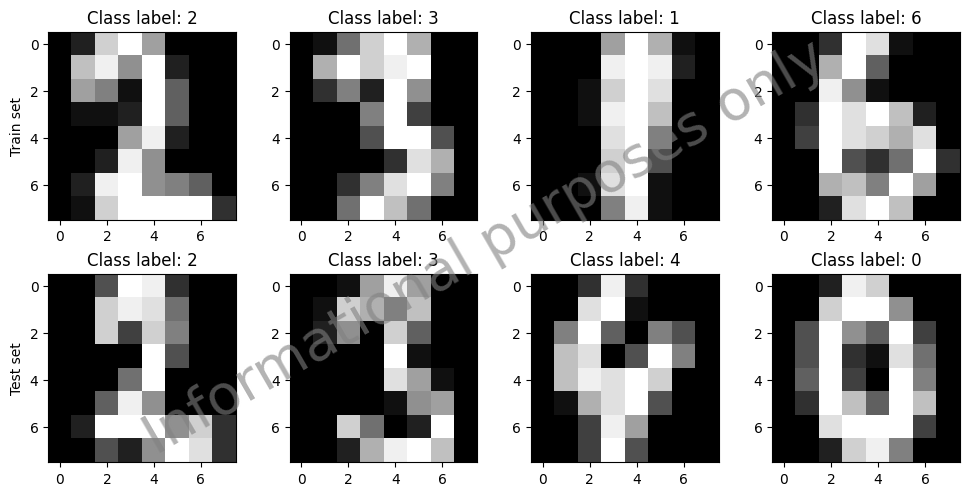

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for idx, ds in enumerate(((X_train, y_train), (X_test, y_test))):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds[0]), size=4)):
        image, label = ds[0][kdx], ds[1][kdx]
        axes[idx, jdx].imshow(image.reshape([8, 8]).numpy(), cmap="gray")
        axes[idx, jdx].set_title(f"Class label: {label}")

axes[0, 0].set_ylabel("Train set")
axes[1, 0].set_ylabel("Test set")

fig.text(
    0.5,
    0.5,
    "Informational purposes only",
    fontsize=40,
    color="gray",
    alpha=0.6,
    ha="center",
    va="center",
    rotation=30,
)

fig.tight_layout()
plt.show()


## Neural network training. [2 pts]

Now everything is ready to train the neural network. There are many optimizers implemented in **Pytorch** for gradient optimization. In this task we will use the **LBFGS** optimizer (class `torch.optim.LBFGS`).

Most optimizers in **Pytorch** are derived from the `torch.optim.Optimizer` base class and look like this:
```python

class OptimizerExample(torch.optim.Optimizer):
    def __init__(self, params, **hyperparameters):
        '''
        Optimizer constructor
        
        :param params: a list or generator of model trainable parameters
        :param hyperparameters: optimizer hyperparameters, e.g., learning rate
        '''
        super().__init__(params, hyperparameters)
    
        
    def step(self, closure=None):
        '''
        A function that performs an optimization step using gradients stored in self.params tensors
        '''
        ...
        
    def zero_grad(self):
        '''
        A function that zeros out gradients stored in tensors self.params
        '''
        ...
```

Note that optimizers in **PyTorch** usually do not control the calculation of gradients, but only use the values of the `grad` attribute of the trained parameters. This allows you to separate the calculation of the loss function, the calculation of gradients, and the optimization step itself into separate components, which makes the code more readable.

Most optimizers support two use-cases:
1. A simple case in which the `step` method is used after the gradients have been calculated (for example, through a `backward` call)
2. An advanced case in which the calculation of gradients is encapsulated in the `closure` function, which is passed to the `step` method as a single parameter. There are at least two arguments in favor of this option:
     * This approach allows you to explicitly select a separate function in the code that calculates model gradients, which improves code readability
     * Some optimizers (for example, those implementing the LBFGS and Conjugate Gradient Method algorithms) require multiple calculations of gradients to perform one optimization step, which is implemented by selecting a separate function for calculating gradients
    
So the `closure` function does the following:
1. Clears gradients of trained parameters, for example, by calling the `zero_grad` method in the optimizer
2. Calculates the loss function and its gradient
3. Returns the value of the loss function
    
In this task, it is proposed to use the **LBFGS** optimizer. Although in practice this choice is not very popular due to its large memory requirements, this algorithm is robust to the choice of learning rate, which will eliminate the selection of this hyperparameter in the task. Another drawback is that this method requires calculating the full gradient (that is, passing through the entire sample), and not the gradient over the minibatch. This makes the method computationally intensive, but on the other hand, it eliminates the need to search for another parameter — batch size.

Create a neural network, optimizer and loss function class:

In [21]:
dense_network = DenseNetwork(
    in_features=in_features,
    hidden_size=hidden_size,
    n_classes=n_classes,
    n_layers=3,
    activation=ReLU,
)

# By default, LBFGS can do several optimization steps internally.
# To limit this behavior, set max_iter to 1
optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
loss_fn = CrossEntropyLoss()


In [22]:
dense_network, optimizer, loss_fn


(DenseNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=64, out_features=32)
     (1): Linear(in_features=32, out_features=32)
     (2): Linear(in_features=32, out_features=10)
   )
   (activation): ReLU()
 ),
 LBFGS (
 Parameter Group 0
     history_size: 100
     line_search_fn: None
     lr: 1
     max_eval: 1
     max_iter: 1
     tolerance_change: 1e-09
     tolerance_grad: 1e-07
 ),
 CrossEntropyLoss())

One of the main advantages of **PyTorch** is the ability to use an accelerator (GPU), which reduces computation time by orders of magnitude. At the same time, Pytorch allows you to write code in such a way that it runs on any device, be it a CPU, or GPU, or TPU/XML (device-agnostic code). To do this, Pytorch implements a wrapper class `torch.device`, containing information about the device on which the calculations will be performed:

In [23]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda", 0)

print(type(device), device)


<class 'torch.device'> cpu


To transfer all model parameters to the desired device, you can use the `to` method:

In [24]:
dense_network.to(device), next(iter(dense_network.parameters()))


(DenseNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=64, out_features=32)
     (1): Linear(in_features=32, out_features=32)
     (2): Linear(in_features=32, out_features=10)
   )
   (activation): ReLU()
 ),
 Parameter containing:
 tensor([[-0.0011, -0.0312,  0.0125,  ..., -0.0006, -0.0063,  0.0061],
         [ 0.0064, -0.0108,  0.0149,  ...,  0.0028,  0.0068, -0.0071],
         [-0.0031,  0.0169, -0.0020,  ...,  0.0102,  0.0119, -0.0125],
         ...,
         [ 0.0020,  0.0117,  0.0048,  ..., -0.0072, -0.0039,  0.0129],
         [ 0.0033, -0.0108, -0.0170,  ...,  0.0004,  0.0087,  0.0015],
         [-0.0143,  0.0077,  0.0095,  ...,  0.0012,  0.0078,  0.0038]],
        requires_grad=True))

Now all that remains is to implement the optimization cycle and calculate metrics.

**Display accuracy values in percents throughout training.**

Implement a model training loop in the `training_loop` function:

In [25]:
import tqdm.notebook as tqdm


def accuracy(output, labels):
    """
    Compute the accuracy of the network's predictions
    :param torch.Tensor output: Logit matrix of size [batch_size, n_classes]
    :param torch.Tensor labels: Array of ground truth labels of size [batch_size]
    :returns: Accuracy value
    """
    return 100 * (output.argmax(dim=1) == labels).float().mean().item()


def training_loop(n_epochs, network, loss_fn, optimizer, ds_train, ds_test, device):
    """
    :param int n_epochs: Number of training iterations
    :param torch.nn.Module network: Neural network instance
    :param Callable loss_fn: Loss function instance
    :param torch.nn.Optimizer optimizer: Optimizer instance
    :param Tuple[torch.Tensor, torch.Tensor] ds_train: Features and ground truth labels of a train set
    :param Tuple[torch.Tensor, torch.Tensor] ds_test: Features and ground truth labels of a test set
    :param torch.Device device: Computation device
    :returns: List of loss and accuracy values on the train and test sets after each iteration
    """
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    network = network.to(device)
    X_train, y_train = ds_train
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = ds_test
    X_test, y_test = X_test.to(device), y_test.to(device)

    for epoch in tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True):
        # Set training mode for the network
        network.train()

        # Training iteration
        def closure():
            """
            Closure function for calculating the gradients of the loss function over the training set:
                1. Zero out current gradients
                2. Do a forward pass through the network to compute the loss function
                3. Compute the gradients of the loss function
            :returns: Loss function value
            """
            optimizer.zero_grad()
            output = network(X_train)
            loss = loss_fn(output, y_train)
            loss.backward()
            return loss

        # Optimization step
        optimizer.step(closure)

        # Set evaluation mode for the network
        network.eval()

        # When evaluating the network there is no need to compute gradients,
        # so you can disable automatic differentiation to speed up operations
        with torch.no_grad():
            # Compute accuracy and loss function on the train set
            output = network(X_train)
            loss = loss_fn(output, y_train)
            train_losses.append(loss.item())
            train_accuracies.append(accuracy(output, y_train))

            # Compute accuracy and loss function on the test set
            output = network(X_test)
            loss = loss_fn(output, y_test)
            test_losses.append(loss.item())
            test_accuracies.append(accuracy(output, y_test))

            if epoch % 20 == 0:
                print(
                    "Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}".format(
                        train_losses[-1],
                        test_losses[-1],
                        train_accuracies[-1],
                        test_accuracies[-1],
                    )
                )

    return train_losses, test_losses, train_accuracies, test_accuracies


Let's train the network. In all experiments, train the network for $200$ epochs with the `max_iter=1` parameter in the optimizer.

In [26]:
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=200,
    network=dense_network,
    loss_fn=loss_fn,
    optimizer=optimizer,
    ds_train=(X_train, y_train),
    ds_test=(X_test, y_test),
    device=device,
)


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 0.711/0.659. Accuracy, % (Train/Test): 75.87/77.78
Loss (Train/Test): 0.065/0.205. Accuracy, % (Train/Test): 98.07/95.78
Loss (Train/Test): 0.000/1.804. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.842. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.842. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.842. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.842. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.842. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.842. Accuracy, % (Train/Test): 100.00/95.56


Print the final quality and value of the loss function for train (`X_train`, `y_train`) and test (`X_test`, `y_test`):

In [27]:
print(f"Cross Entropy (Train/Test): {train_losses[-1]:.3f}/{test_losses[-1]:.3f}")
print(f"Accuracy (Train/Test): {train_accs[-1]:.3f}/{test_accs[-1]:.3f}")


Cross Entropy (Train/Test): 0.000/2.842
Accuracy (Train/Test): 100.000/95.556


Let us plot the accuracy for training and test over iterations:

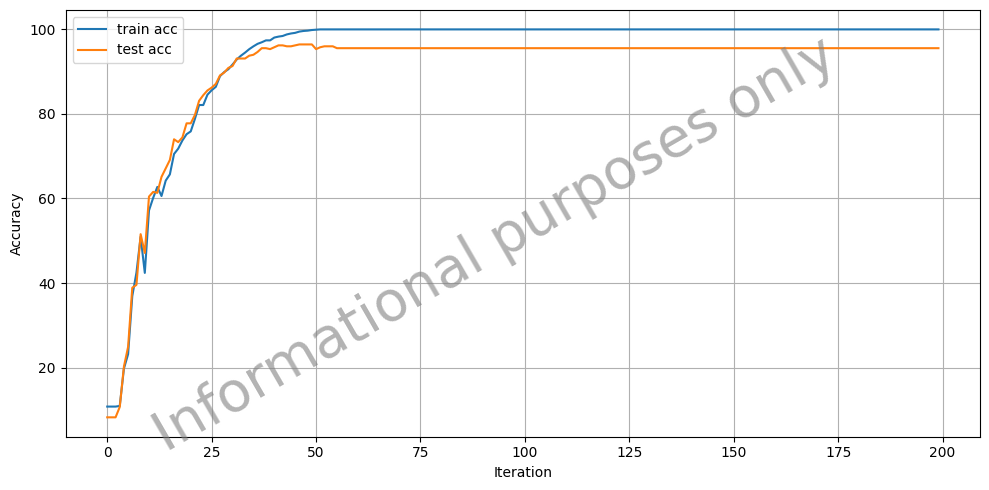

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="train acc")
ax.plot(test_accs, label="test acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid(True)
ax.legend()

fig.text(
    0.5,
    0.5,
    "Informational purposes only",
    fontsize=40,
    color="gray",
    alpha=0.6,
    ha="center",
    va="center",
    rotation=30,
)

fig.tight_layout()
plt.show()


## Experiments with the number of layers. [3 pts]

It is clear that due to the random initialization, we will get different quality with each training run. Let's try to train our neural network with varying number of layers several times.

Fill in the `accs_train` and `accs_test` matrices. Position `[i, j]` should contain the value of the share of correct answers of the network with $i+1$ fully connected layers at the $j$-th run (all runs are identical, that is, the same training hyperparameters are used).

In [29]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))


In [30]:
from torch import nn

for i in range(5):
    dense_network = DenseNetwork(
        in_features=in_features,
        hidden_size=hidden_size,
        n_classes=n_classes,
        n_layers=i + 1,
        activation=ReLU,
    )
    for j in range(5):
        optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()

        train_losses, test_losses, train_accs, test_accs = training_loop(
            n_epochs=200,
            network=dense_network,
            loss_fn=loss_fn,
            optimizer=optimizer,
            ds_train=(X_train, y_train),
            ds_test=(X_test, y_test),
            device=device,
        )
        accs_train[i, j] = train_accs[-1]
        accs_test[i, j] = test_accs[-1]


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.285/2.290. Accuracy, % (Train/Test): 20.19/19.33
Loss (Train/Test): 0.246/0.225. Accuracy, % (Train/Test): 92.72/91.56
Loss (Train/Test): 0.014/0.210. Accuracy, % (Train/Test): 99.63/96.67
Loss (Train/Test): 0.000/1.022. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.319. Accuracy, % (Train/Test): 100.00/96.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.292/2.294. Accuracy, % (Train/Test): 22.49/19.33
Loss (Train/Test): 0.112/0.156. Accuracy, % (Train/Test): 96.59/94.89
Loss (Train/Test): 0.000/0.600. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.476. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.263/1.230. Accuracy, % (Train/Test): 56.87/58.44
Loss (Train/Test): 0.319/0.338. Accuracy, % (Train/Test): 89.76/89.33
Loss (Train/Test): 0.090/0.254. Accuracy, % (Train/Test): 97.40/93.11
Loss (Train/Test): 0.020/0.521. Accuracy, % (Train/Test): 99.48/94.00
Loss (Train/Test): 0.000/5.028. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/12.362. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/15.846. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.799/1.789. Accuracy, % (Train/Test): 24.50/27.11
Loss (Train/Test): 1.226/1.321. Accuracy, % (Train/Test): 52.64/51.56
Loss (Train/Test): 0.647/0.786. Accuracy, % (Train/Test): 74.76/71.33
Loss (Train/Test): 0.291/0.432. Accuracy, % (Train/Test): 87.90/86.44
Loss (Train/Test): 0.105/0.350. Accuracy, % (Train/Test): 96.44/93.56
Loss (Train/Test): 0.044/0.562. Accuracy, % (Train/Test): 98.66/93.33
Loss (Train/Test): 0.008/1.610. Accuracy, % (Train/Test): 99.85/93.33
Loss (Train/Test): 0.000/5.080. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/9.913. Accuracy, % (Train/Test): 100.00/93.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/13.325. Accuracy, % (Train/Test): 100.00/93.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.295/2.294. Accuracy, % (Train/Test): 10.24/10.67
Loss (Train/Test): 1.203/1.196. Accuracy, % (Train/Test): 49.81/52.44
Loss (Train/Test): 0.816/0.846. Accuracy, % (Train/Test): 70.08/73.33
Loss (Train/Test): 0.571/0.671. Accuracy, % (Train/Test): 79.88/76.89
Loss (Train/Test): 0.487/0.595. Accuracy, % (Train/Test): 83.00/80.89
Loss (Train/Test): 0.221/0.334. Accuracy, % (Train/Test): 91.76/89.33
Loss (Train/Test): 0.089/0.299. Accuracy, % (Train/Test): 96.96/94.44
Loss (Train/Test): 0.027/0.510. Accuracy, % (Train/Test): 99.03/94.89
Loss (Train/Test): 0.005/1.206. Accuracy, % (Train/Test): 99.85/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.628/4.341. Accuracy, % (Train/Test): 96.59/92.22
Loss (Train/Test): 0.000/3.280. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/3.049. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/2.893. Accuracy, % (Train/Test): 100.00/95.56


Let's build boxplots of the obtained quality (the horizontal line in each column is the average, the rectangle shows the spread).

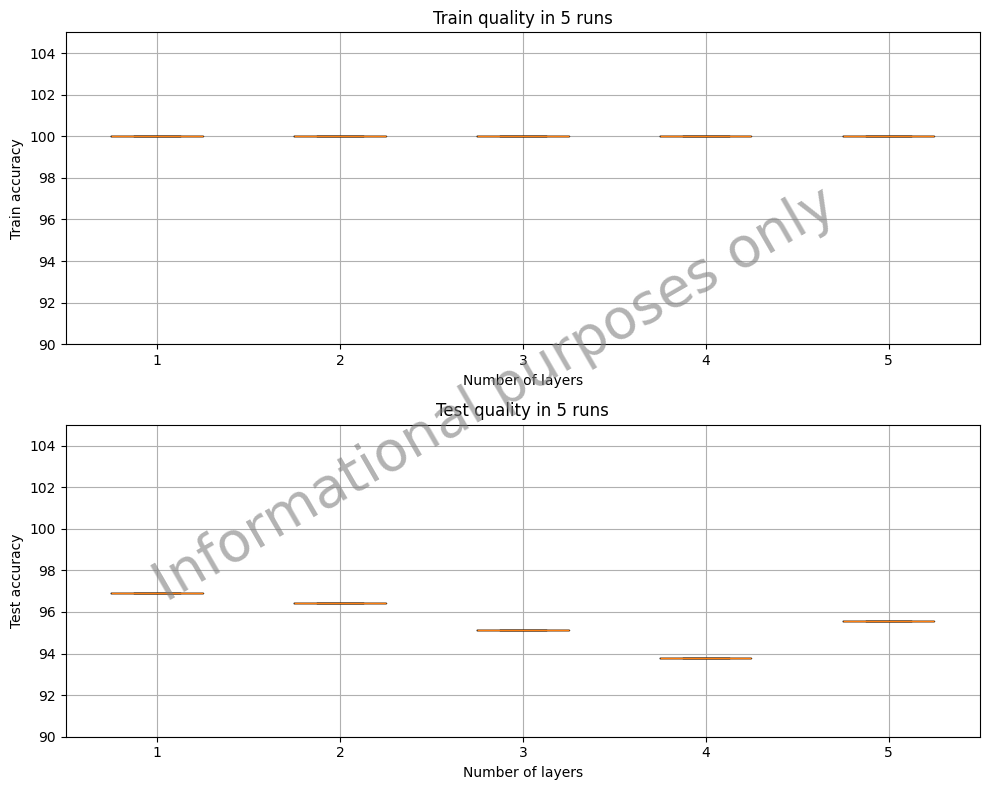

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, showfliers=False)
axes[1].boxplot(accs_test.T, showfliers=False)

axes[0].set_xlabel("Number of layers")
axes[1].set_xlabel("Number of layers")

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_ylim(90, 105)
axes[1].set_ylim(90, 105)

axes[0].set_title("Train quality in 5 runs")
axes[1].set_title("Test quality in 5 runs")

axes[0].grid(True)
axes[1].grid(True)

fig.text(
    0.5,
    0.5,
    "Informational purposes only",
    fontsize=40,
    color="gray",
    alpha=0.6,
    ha="center",
    va="center",
    rotation=30,
)

fig.tight_layout()
plt.show()


Give a detailed answer to the questions (in the same cell):
1. How do the training and testing accuracy and the stability of the learning process change as the number of layers increases?
2. Is it true that logistic regression (linear model) gives worse quality than a non-linear model?

__Answers:__

Training accuracy is stable at $100\%$ for all number of layers. With testing accuracy some kind of double descent happens where before $4$ layers the model overfits, but at $5$ gets slightly better.

One-layer model gives the best results here.

## Experiments with different weights initialization. [3 pts]

As already mentioned, the initialization of the weights of a neural network can greatly influence the process of its training and, as a result, the final quality.

At this point, you are to try training several neural networks with different layer initializations.

To do this, it is necessary to implement a function that initializes the weights of the linear layers of our neural network. We will use the [`apply`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply) method defined in the `torch.nn.Module class`. This method allows you to recursively apply a custom function to all submodules of a given module.

Implement the `initialize_module` function. Add to its functionality the ability to initialize the weights of the network using:
1. **Kaiming initialization** (used if the neural network uses ReLU as activation functions)
2. **Xavier initialization** (used if the neural network uses Tanh or Sigmoid as activation functions)
3. **Initialization by normal distribution** with zero mean and given variance

**Note:** The `apply` method is applied recursively to all modules. To initialize linear layers, you need to check whether this module is an instance of the `Linear` class. You can use the built-in `isinstance` method for this check.

In [88]:
def initialize_module(module, init):
    """
    Initialization of a linear module with specified parameters
    :param torch.nn.Module module: The module to be initialized
    :param Union[str, float] init: Depending on the value, the weight matrix is initialized:
        * init == 'Kaiming': Kaiming initialization
        * init == 'Xavier': Xavier initialization
        * isinstance(init, float): initialize from normal distribution with standard deviation init
        The bias vector is always initialized with zeros
    """
    if isinstance(module, Linear):
        if init == "Kaiming":
            torch.nn.init.kaiming_normal_(module.weight)
        elif init == "Xavier":
            torch.nn.init.xavier_normal_(module.weight)
        elif isinstance(init, float):
            torch.nn.init.normal_(module.weight, mean=0, std=init)
        torch.nn.init.zeros_(module.bias)


Now try to train the neural network several times for each of the $3$ initializations. Try to perform this operation with a fixed number of layers equal to $3$, $4$ and $5$.

### 3 layers

Fix the number of layers in the network equal to three.

Fill in the `accs_train` and `accs_test` matrices. Position `[i, j]` should contain the accuracy value of the network during the $j$th run (all runs are identical) with Kaiming initialization at $i = 3$, with Xavier initialization at $i = 4$, and with initialization from a normal distribution with fixed parameters at $0 \leqslant i \leqslant 2$ (try $3$ different parameters for the standard deviation for a normal distribution, for example: `1e-3`, `1e-2`, `1e-1`). Note that with a large number of layers, too small standard deviation may prevent the neural network from learning properly.

In [89]:
init_vars = [1e-3, 1e-2, 1e-1, "Kaiming", "Xavier"]


In [90]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))


In [91]:
from functools import partial

for i in range(5):
    for j in range(5):
        dense_network = DenseNetwork(
            in_features=in_features,
            hidden_size=hidden_size,
            n_classes=n_classes,
            n_layers=3,
            activation=ReLU,
        )
        dense_network.apply(partial(initialize_module, init=init_vars[i]))
        optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()

        train_losses, test_losses, train_accs, test_accs = training_loop(
            n_epochs=200,
            network=dense_network,
            loss_fn=loss_fn,
            optimizer=optimizer,
            ds_train=(X_train, y_train),
            ds_test=(X_test, y_test),
            device=device,
        )
        accs_train[i, j] = train_accs[-1]
        accs_test[i, j] = test_accs[-1]


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.391/1.402. Accuracy, % (Train/Test): 46.70/45.78
Loss (Train/Test): 0.382/0.457. Accuracy, % (Train/Test): 87.75/87.56
Loss (Train/Test): 0.047/0.337. Accuracy, % (Train/Test): 98.74/94.00
Loss (Train/Test): 0.000/2.261. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.902. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/5.902. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/5.902. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/5.902. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/5.902. Accuracy, % (Train/Test): 100.00/94.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.608/1.590. Accuracy, % (Train/Test): 33.56/30.89
Loss (Train/Test): 0.903/0.900. Accuracy, % (Train/Test): 68.37/72.22
Loss (Train/Test): 0.378/0.379. Accuracy, % (Train/Test): 88.64/89.11
Loss (Train/Test): 0.081/0.311. Accuracy, % (Train/Test): 98.00/94.00
Loss (Train/Test): 0.002/1.234. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/6.169. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/8.072. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/8.072. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/8.072. Accuracy, % (Train/Test): 100.00/95.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.397/1.392. Accuracy, % (Train/Test): 54.19/55.56
Loss (Train/Test): 0.555/0.527. Accuracy, % (Train/Test): 81.74/85.11
Loss (Train/Test): 0.148/0.187. Accuracy, % (Train/Test): 95.40/93.78
Loss (Train/Test): 0.018/0.421. Accuracy, % (Train/Test): 99.33/96.22
Loss (Train/Test): 0.000/1.806. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/4.189. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/4.189. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/4.189. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/4.189. Accuracy, % (Train/Test): 100.00/96.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 15.150/15.597. Accuracy, % (Train/Test): 23.39/18.00
Loss (Train/Test): 0.395/0.430. Accuracy, % (Train/Test): 86.93/84.67
Loss (Train/Test): 0.040/0.237. Accuracy, % (Train/Test): 98.74/95.78
Loss (Train/Test): 0.000/1.084. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/3.526. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/3.526. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/3.526. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/3.526. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/3.526. Accuracy, % (Train/Test): 100.00/94.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.604/1.543. Accuracy, % (Train/Test): 31.92/35.78
Loss (Train/Test): 0.387/0.403. Accuracy, % (Train/Test): 88.64/86.89
Loss (Train/Test): 0.058/0.278. Accuracy, % (Train/Test): 98.14/94.67
Loss (Train/Test): 0.001/1.884. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/7.834. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/8.591. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/8.591. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/8.591. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/8.591. Accuracy, % (Train/Test): 100.00/94.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.017/1.067. Accuracy, % (Train/Test): 63.62/61.11
Loss (Train/Test): 0.159/0.229. Accuracy, % (Train/Test): 94.88/93.33
Loss (Train/Test): 0.018/0.329. Accuracy, % (Train/Test): 99.55/95.78
Loss (Train/Test): 0.000/2.011. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.318. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.318. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.318. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.318. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/2.318. Accuracy, % (Train/Test): 100.00/95.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 0.527/0.533. Accuracy, % (Train/Test): 81.96/80.44
Loss (Train/Test): 0.096/0.236. Accuracy, % (Train/Test): 96.51/95.11
Loss (Train/Test): 0.003/0.766. Accuracy, % (Train/Test): 99.93/95.11
Loss (Train/Test): 0.000/3.142. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/3.262. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/3.262. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/3.262. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/3.262. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/3.262. Accuracy, % (Train/Test): 100.00/94.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 0.659/0.610. Accuracy, % (Train/Test): 78.54/78.67
Loss (Train/Test): 0.182/0.326. Accuracy, % (Train/Test): 93.76/90.67
Loss (Train/Test): 0.027/0.427. Accuracy, % (Train/Test): 98.96/95.78
Loss (Train/Test): 0.000/2.569. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/7.028. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/7.028. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/7.028. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/7.028. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/7.028. Accuracy, % (Train/Test): 100.00/95.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.84/8.44
Loss (Train/Test): 0.697/0.656. Accuracy, % (Train/Test): 77.58/79.56
Loss (Train/Test): 0.120/0.249. Accuracy, % (Train/Test): 95.40/93.33
Loss (Train/Test): 0.001/1.500. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.586. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.586. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.586. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.586. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.586. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.586. Accuracy, % (Train/Test): 100.00/94.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 0.896/0.917. Accuracy, % (Train/Test): 71.64/71.11
Loss (Train/Test): 0.282/0.397. Accuracy, % (Train/Test): 89.90/87.56
Loss (Train/Test): 0.049/0.239. Accuracy, % (Train/Test): 98.44/95.56
Loss (Train/Test): 0.002/1.205. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/6.884. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/7.573. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/7.573. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/7.573. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/7.573. Accuracy, % (Train/Test): 100.00/94.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.384/2.347. Accuracy, % (Train/Test): 6.53/8.67
Loss (Train/Test): 0.123/0.154. Accuracy, % (Train/Test): 95.84/95.78
Loss (Train/Test): 0.001/0.363. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.288/2.260. Accuracy, % (Train/Test): 14.63/16.00
Loss (Train/Test): 0.116/0.126. Accuracy, % (Train/Test): 96.14/96.67
Loss (Train/Test): 0.001/0.449. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.277. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.277. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.277. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.277. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.277. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.277. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.277. Accuracy, % (Train/Test): 100.00/96.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.433/2.407. Accuracy, % (Train/Test): 9.50/11.56
Loss (Train/Test): 0.261/0.241. Accuracy, % (Train/Test): 91.31/90.89
Loss (Train/Test): 0.012/0.357. Accuracy, % (Train/Test): 99.63/95.11
Loss (Train/Test): 0.000/1.541. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/2.645. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.645. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.645. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.645. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.645. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.645. Accuracy, % (Train/Test): 100.00/94.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.385/2.410. Accuracy, % (Train/Test): 11.06/11.56
Loss (Train/Test): 0.152/0.195. Accuracy, % (Train/Test): 95.92/95.11
Loss (Train/Test): 0.004/0.282. Accuracy, % (Train/Test): 99.93/96.89
Loss (Train/Test): 0.000/1.227. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.356. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.356. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.356. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.356. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.356. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.356. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.382/2.356. Accuracy, % (Train/Test): 14.77/17.11
Loss (Train/Test): 0.131/0.145. Accuracy, % (Train/Test): 95.77/95.78
Loss (Train/Test): 0.002/0.412. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.317. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.371. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.371. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.371. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.371. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.371. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.371. Accuracy, % (Train/Test): 100.00/96.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 19.796/19.824. Accuracy, % (Train/Test): 13.59/13.11
Loss (Train/Test): 0.361/0.431. Accuracy, % (Train/Test): 88.57/86.67
Loss (Train/Test): 0.022/0.274. Accuracy, % (Train/Test): 99.63/95.56
Loss (Train/Test): 0.000/0.623. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.942. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.942. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.942. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.942. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.942. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.942. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 23.342/23.234. Accuracy, % (Train/Test): 11.21/11.56
Loss (Train/Test): 0.196/0.322. Accuracy, % (Train/Test): 93.76/91.56
Loss (Train/Test): 0.002/0.291. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.579. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 32.721/28.939. Accuracy, % (Train/Test): 6.90/9.56
Loss (Train/Test): 0.463/0.606. Accuracy, % (Train/Test): 83.37/80.22
Loss (Train/Test): 0.037/0.282. Accuracy, % (Train/Test): 99.11/94.89
Loss (Train/Test): 0.003/0.433. Accuracy, % (Train/Test): 99.85/95.56
Loss (Train/Test): 0.002/0.574. Accuracy, % (Train/Test): 99.85/96.22
Loss (Train/Test): 0.000/0.820. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.965. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.965. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.965. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.965. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 46.586/46.449. Accuracy, % (Train/Test): 10.54/9.56
Loss (Train/Test): 0.538/0.601. Accuracy, % (Train/Test): 82.85/82.67
Loss (Train/Test): 0.039/0.199. Accuracy, % (Train/Test): 98.89/94.89
Loss (Train/Test): 0.000/0.414. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.825. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.825. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.825. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.825. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.825. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.825. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 32.067/29.772. Accuracy, % (Train/Test): 15.22/17.56
Loss (Train/Test): 0.129/0.206. Accuracy, % (Train/Test): 95.40/93.56
Loss (Train/Test): 0.000/0.392. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.817. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.817. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.817. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.817. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.817. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.817. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.817. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.187/7.783. Accuracy, % (Train/Test): 6.53/6.89
Loss (Train/Test): 0.106/0.206. Accuracy, % (Train/Test): 96.59/94.44
Loss (Train/Test): 0.001/0.224. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/96.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 6.086/5.874. Accuracy, % (Train/Test): 8.24/7.33
Loss (Train/Test): 0.125/0.188. Accuracy, % (Train/Test): 96.29/95.33
Loss (Train/Test): 0.000/0.291. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/0.695. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.695. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.695. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.695. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.695. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.695. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.695. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 6.970/7.873. Accuracy, % (Train/Test): 7.87/7.56
Loss (Train/Test): 0.141/0.171. Accuracy, % (Train/Test): 95.84/94.44
Loss (Train/Test): 0.001/0.196. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.442. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/0.442. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/0.442. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/0.442. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/0.442. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/0.442. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/0.442. Accuracy, % (Train/Test): 100.00/97.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.103/7.228. Accuracy, % (Train/Test): 9.50/9.56
Loss (Train/Test): 0.066/0.176. Accuracy, % (Train/Test): 97.62/94.89
Loss (Train/Test): 0.000/0.332. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.900. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.900. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.900. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.900. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.900. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.900. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.900. Accuracy, % (Train/Test): 100.00/97.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.553/7.603. Accuracy, % (Train/Test): 13.44/14.89
Loss (Train/Test): 0.081/0.183. Accuracy, % (Train/Test): 97.77/95.33
Loss (Train/Test): 0.001/0.302. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.844. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.844. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.844. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.844. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.844. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.844. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.844. Accuracy, % (Train/Test): 100.00/95.33


Let's draw boxplots of the obtained accuracy (the horizontal line in each column is the average, the rectangle shows the spread).

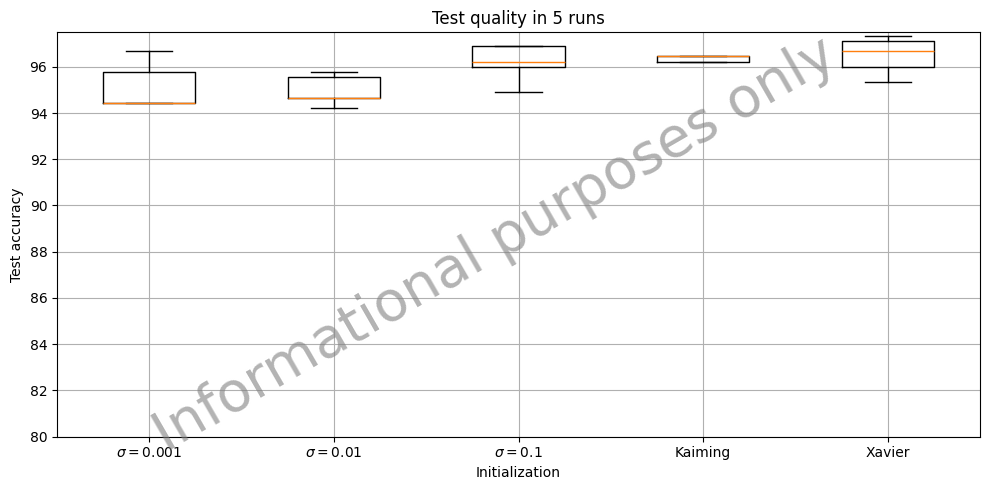

In [92]:
init_vars_for_plot = [
    (x if isinstance(x, str) else rf"$\sigma = {x}$") for x in init_vars
]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, tick_labels=init_vars_for_plot, showfliers=False)

ax.set_ylim(80)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.text(
    0.5,
    0.5,
    "Informational purposes only",
    fontsize=40,
    color="gray",
    alpha=0.6,
    ha="center",
    va="center",
    rotation=30,
)

fig.tight_layout()
plt.show()


### 4 layers

Run the same code as in the previous paragraph, but only with $4$ layers in the network.

In [93]:
init_vars = [1e-3, 1e-2, 1e-1, "Kaiming", "Xavier"]


In [94]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))


In [95]:
for i in range(5):
    for j in range(5):
        dense_network = DenseNetwork(
            in_features=in_features,
            hidden_size=hidden_size,
            n_classes=n_classes,
            n_layers=4,
            activation=ReLU,
        )
        dense_network.apply(partial(initialize_module, init=init_vars[i]))
        optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()

        train_losses, test_losses, train_accs, test_accs = training_loop(
            n_epochs=200,
            network=dense_network,
            loss_fn=loss_fn,
            optimizer=optimizer,
            ds_train=(X_train, y_train),
            ds_test=(X_test, y_test),
            device=device,
        )
        accs_train[i, j] = train_accs[-1]
        accs_test[i, j] = test_accs[-1]


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.007/2.057. Accuracy, % (Train/Test): 26.06/25.33
Loss (Train/Test): 0.868/0.851. Accuracy, % (Train/Test): 69.71/67.11
Loss (Train/Test): 0.448/0.543. Accuracy, % (Train/Test): 82.55/81.33
Loss (Train/Test): 0.217/0.409. Accuracy, % (Train/Test): 92.43/89.11
Loss (Train/Test): 0.057/0.319. Accuracy, % (Train/Test): 98.22/93.78
Loss (Train/Test): 0.004/1.679. Accuracy, % (Train/Test): 99.85/93.33
Loss (Train/Test): 0.000/7.530. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/11.877. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/11.877. Accuracy, % (Train/Test): 100.00/93.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.728/1.777. Accuracy, % (Train/Test): 34.22/31.11
Loss (Train/Test): 0.482/0.486. Accuracy, % (Train/Test): 85.60/85.11
Loss (Train/Test): 0.118/0.247. Accuracy, % (Train/Test): 96.73/95.11
Loss (Train/Test): 0.010/0.530. Accuracy, % (Train/Test): 99.55/95.11
Loss (Train/Test): 0.000/2.078. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.479. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.479. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.479. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.479. Accuracy, % (Train/Test): 100.00/94.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.875/1.900. Accuracy, % (Train/Test): 22.35/21.33
Loss (Train/Test): 0.859/0.797. Accuracy, % (Train/Test): 72.90/73.33
Loss (Train/Test): 0.249/0.350. Accuracy, % (Train/Test): 91.61/90.44
Loss (Train/Test): 0.053/0.309. Accuracy, % (Train/Test): 98.37/94.22
Loss (Train/Test): 0.001/1.420. Accuracy, % (Train/Test): 100.00/93.78
Loss (Train/Test): 0.000/4.982. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.160. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.160. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/5.160. Accuracy, % (Train/Test): 100.00/94.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 3.152/3.065. Accuracy, % (Train/Test): 9.43/8.67
Loss (Train/Test): 2.192/2.188. Accuracy, % (Train/Test): 13.44/12.44
Loss (Train/Test): 1.568/1.500. Accuracy, % (Train/Test): 35.93/34.89
Loss (Train/Test): 3.561/3.390. Accuracy, % (Train/Test): 29.18/28.44
Loss (Train/Test): 0.695/0.648. Accuracy, % (Train/Test): 77.65/77.78
Loss (Train/Test): 0.418/0.450. Accuracy, % (Train/Test): 85.89/86.22
Loss (Train/Test): 0.258/0.404. Accuracy, % (Train/Test): 91.76/87.78
Loss (Train/Test): 0.157/0.436. Accuracy, % (Train/Test): 93.69/89.78
Loss (Train/Test): 0.088/0.482. Accuracy, % (Train/Test): 96.96/91.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.420/1.393. Accuracy, % (Train/Test): 51.89/52.89
Loss (Train/Test): 0.447/0.526. Accuracy, % (Train/Test): 83.00/81.11
Loss (Train/Test): 0.096/0.306. Accuracy, % (Train/Test): 97.10/93.11
Loss (Train/Test): 0.007/0.814. Accuracy, % (Train/Test): 99.93/94.22
Loss (Train/Test): 0.000/4.207. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/6.557. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/6.557. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/6.557. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/6.557. Accuracy, % (Train/Test): 100.00/94.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.287/2.292. Accuracy, % (Train/Test): 11.73/11.11
Loss (Train/Test): 0.663/0.643. Accuracy, % (Train/Test): 74.54/77.11
Loss (Train/Test): 0.119/0.243. Accuracy, % (Train/Test): 95.99/92.89
Loss (Train/Test): 0.006/0.450. Accuracy, % (Train/Test): 99.78/96.67
Loss (Train/Test): 0.000/2.078. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/2.601. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.601. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.601. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.601. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.601. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.318/2.316. Accuracy, % (Train/Test): 7.42/9.56
Loss (Train/Test): 0.518/0.565. Accuracy, % (Train/Test): 82.78/80.67
Loss (Train/Test): 0.116/0.232. Accuracy, % (Train/Test): 96.44/93.11
Loss (Train/Test): 0.018/0.337. Accuracy, % (Train/Test): 99.26/95.33
Loss (Train/Test): 0.000/1.421. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/3.185. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/3.185. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/3.185. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/3.185. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/3.185. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.288/2.304. Accuracy, % (Train/Test): 11.21/9.11
Loss (Train/Test): 0.402/0.417. Accuracy, % (Train/Test): 86.56/86.44
Loss (Train/Test): 0.032/0.198. Accuracy, % (Train/Test): 99.11/94.67
Loss (Train/Test): 0.000/1.077. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.972. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.972. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.972. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.972. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.972. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.972. Accuracy, % (Train/Test): 100.00/95.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.386/2.377. Accuracy, % (Train/Test): 11.58/10.00
Loss (Train/Test): 0.350/0.364. Accuracy, % (Train/Test): 90.35/88.67
Loss (Train/Test): 0.049/0.238. Accuracy, % (Train/Test): 98.44/95.11
Loss (Train/Test): 0.000/1.049. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/2.863. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.863. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.863. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.863. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.863. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/2.863. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.308/2.309. Accuracy, % (Train/Test): 10.62/9.78
Loss (Train/Test): 0.260/0.235. Accuracy, % (Train/Test): 91.98/92.44
Loss (Train/Test): 0.012/0.231. Accuracy, % (Train/Test): 99.78/96.67
Loss (Train/Test): 0.000/0.925. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/1.175. Accuracy, % (Train/Test): 100.00/97.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 31.880/31.822. Accuracy, % (Train/Test): 9.95/10.22
Loss (Train/Test): 0.354/0.445. Accuracy, % (Train/Test): 88.79/86.44
Loss (Train/Test): 0.010/0.206. Accuracy, % (Train/Test): 99.78/96.22
Loss (Train/Test): 0.000/0.353. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/0.607. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.607. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.607. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.607. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.607. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.607. Accuracy, % (Train/Test): 100.00/96.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 71.359/70.980. Accuracy, % (Train/Test): 9.80/10.67
Loss (Train/Test): 0.435/0.512. Accuracy, % (Train/Test): 86.04/85.33
Loss (Train/Test): 0.016/0.182. Accuracy, % (Train/Test): 99.55/96.22
Loss (Train/Test): 0.000/0.456. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.694. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.694. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.694. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.694. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.694. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.694. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 17.216/18.413. Accuracy, % (Train/Test): 12.69/13.33
Loss (Train/Test): 0.402/0.559. Accuracy, % (Train/Test): 87.23/83.78
Loss (Train/Test): 0.017/0.330. Accuracy, % (Train/Test): 99.63/94.22
Loss (Train/Test): 0.000/0.604. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.046. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.046. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.046. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.046. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.046. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.046. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 20.239/19.105. Accuracy, % (Train/Test): 14.70/15.33
Loss (Train/Test): 0.314/0.387. Accuracy, % (Train/Test): 89.31/86.22
Loss (Train/Test): 0.009/0.215. Accuracy, % (Train/Test): 99.93/95.78
Loss (Train/Test): 0.000/0.515. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.692. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.692. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.692. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.692. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.692. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.692. Accuracy, % (Train/Test): 100.00/95.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 19.040/18.760. Accuracy, % (Train/Test): 7.80/7.11
Loss (Train/Test): 0.135/0.292. Accuracy, % (Train/Test): 95.17/92.00
Loss (Train/Test): 0.003/0.296. Accuracy, % (Train/Test): 99.93/95.56
Loss (Train/Test): 0.000/0.434. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/0.461. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.461. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.461. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.461. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.461. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.461. Accuracy, % (Train/Test): 100.00/95.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 4.657/4.734. Accuracy, % (Train/Test): 4.31/5.78
Loss (Train/Test): 0.174/0.265. Accuracy, % (Train/Test): 94.95/92.44
Loss (Train/Test): 0.002/0.297. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/0.836. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.907. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.907. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.907. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.907. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.907. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.907. Accuracy, % (Train/Test): 100.00/97.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 3.997/4.271. Accuracy, % (Train/Test): 9.58/9.11
Loss (Train/Test): 0.156/0.237. Accuracy, % (Train/Test): 94.88/94.67
Loss (Train/Test): 0.000/0.405. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.199. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.199. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.199. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.199. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.199. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.199. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.199. Accuracy, % (Train/Test): 100.00/97.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 3.993/4.097. Accuracy, % (Train/Test): 14.48/13.33
Loss (Train/Test): 0.147/0.188. Accuracy, % (Train/Test): 95.47/94.00
Loss (Train/Test): 0.010/0.200. Accuracy, % (Train/Test): 99.93/96.22
Loss (Train/Test): 0.000/0.414. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.839. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.444/7.756. Accuracy, % (Train/Test): 10.62/8.00
Loss (Train/Test): 0.337/0.330. Accuracy, % (Train/Test): 88.94/88.22
Loss (Train/Test): 0.037/0.111. Accuracy, % (Train/Test): 98.96/96.67
Loss (Train/Test): 0.000/0.644. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/1.893. Accuracy, % (Train/Test): 100.00/94.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 4.367/4.342. Accuracy, % (Train/Test): 12.77/13.78
Loss (Train/Test): 0.140/0.180. Accuracy, % (Train/Test): 94.88/94.44
Loss (Train/Test): 0.002/0.300. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/1.010. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/1.112. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.112. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.112. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.112. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.112. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/1.112. Accuracy, % (Train/Test): 100.00/97.11


Draw the boxplots of the obtained accuracy (the horizontal line in each column is the average, the rectangle shows the spread).

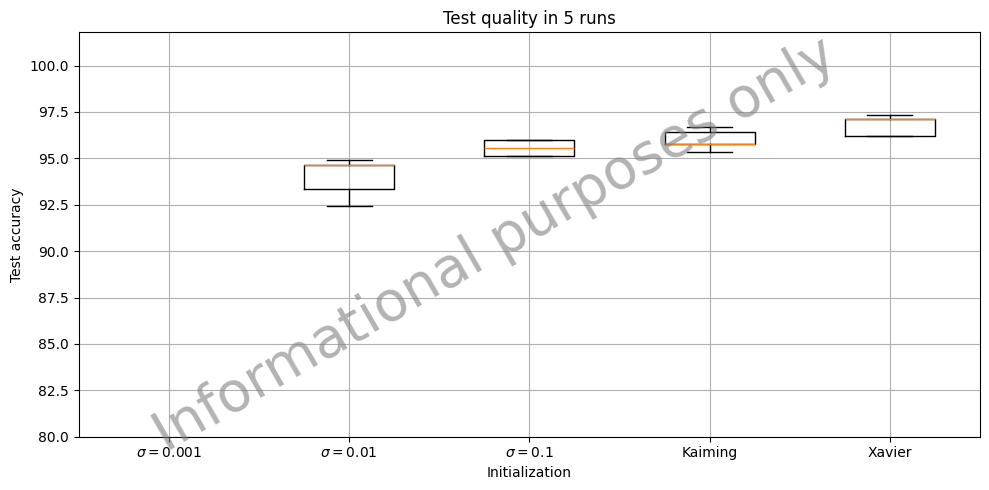

In [96]:
init_vars_for_plot = [
    (x if isinstance(x, str) else rf"$\sigma = {x}$") for x in init_vars
]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, tick_labels=init_vars_for_plot, showfliers=False)

ax.set_ylim(80)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.text(
    0.5,
    0.5,
    "Informational purposes only",
    fontsize=40,
    color="gray",
    alpha=0.6,
    ha="center",
    va="center",
    rotation=30,
)

fig.tight_layout()
plt.show()


### 5 layers

Run the same code as in the previous paragraph, but only with $5$ layers in the network.

In [97]:
init_vars = [1e-3, 1e-2, 1e-1, "Kaiming", "Xavier"]


In [98]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))


In [99]:
for i in range(5):
    for j in range(5):
        dense_network = DenseNetwork(
            in_features=in_features,
            hidden_size=hidden_size,
            n_classes=n_classes,
            n_layers=5,
            activation=ReLU,
        )
        dense_network.apply(partial(initialize_module, init=init_vars[i]))
        optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()

        train_losses, test_losses, train_accs, test_accs = training_loop(
            n_epochs=200,
            network=dense_network,
            loss_fn=loss_fn,
            optimizer=optimizer,
            ds_train=(X_train, y_train),
            ds_test=(X_test, y_test),
            device=device,
        )
        accs_train[i, j] = train_accs[-1]
        accs_test[i, j] = test_accs[-1]


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.295/2.301. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.217/1.240. Accuracy, % (Train/Test): 52.78/54.89
Loss (Train/Test): 0.779/0.773. Accuracy, % (Train/Test): 71.05/74.00
Loss (Train/Test): 0.565/0.600. Accuracy, % (Train/Test): 80.70/81.11
Loss (Train/Test): 0.376/0.479. Accuracy, % (Train/Test): 86.79/86.67
Loss (Train/Test): 0.238/0.437. Accuracy, % (Train/Test): 91.54/87.78
Loss (Train/Test): 0.104/0.375. Accuracy, % (Train/Test): 96.88/92.44
Loss (Train/Test): 0.044/0.481. Accuracy, % (Train/Test): 98.81/93.33
Loss (Train/Test): 0.013/0.896. Accuracy, % (Train/Test): 99.85/93.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.514/2.512. Accuracy, % (Train/Test): 9.95/9.11
Loss (Train/Test): 1.783/1.762. Accuracy, % (Train/Test): 32.22/29.78
Loss (Train/Test): 0.936/0.910. Accuracy, % (Train/Test): 67.33/67.78
Loss (Train/Test): 0.530/0.671. Accuracy, % (Train/Test): 82.26/80.22
Loss (Train/Test): 0.276/0.458. Accuracy, % (Train/Test): 90.35/89.56
Loss (Train/Test): 0.143/0.462. Accuracy, % (Train/Test): 95.55/93.56
Loss (Train/Test): 0.073/0.667. Accuracy, % (Train/Test): 97.48/94.44
Loss (Train/Test): 0.026/1.245. Accuracy, % (Train/Test): 99.11/94.00
Loss (Train/Test): 0.002/2.435. Accuracy, % (Train/Test): 99.93/93.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.295/2.326. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.298/2.291. Accuracy, % (Train/Test): 9.13/13.11
Loss (Train/Test): 2983021739816003355671846191104.000/3239150506357201862113676492800.000. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2983021739816003355671846191104.000/3239150506357201862113676492800.000. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2983021739816003355671846191104.000/3239150506357201862113676492800.000. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2983021739816003355671846191104.000/3239150506357201862113676492800.000. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2983021739816003355671846191104.000/3239150506357201862113676492800.000. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2983021739816003355671846191104.000/3239150506357201862113676492800.000. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.300/2.309. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 1.666/1.705. Accuracy, % (Train/Test): 32.52/30.22
Loss (Train/Test): 1.012/1.045. Accuracy, % (Train/Test): 64.22/65.11
Loss (Train/Test): 0.659/0.815. Accuracy, % (Train/Test): 76.39/72.89
Loss (Train/Test): 0.386/0.568. Accuracy, % (Train/Test): 87.23/84.44
Loss (Train/Test): 0.145/0.412. Accuracy, % (Train/Test): 95.03/90.67
Loss (Train/Test): 0.037/0.563. Accuracy, % (Train/Test): 98.74/91.78
Loss (Train/Test): 0.005/1.429. Accuracy, % (Train/Test): 99.93/92.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 6.929/6.596. Accuracy, % (Train/Test): 19.38/18.89
Loss (Train/Test): 1.578/1.586. Accuracy, % (Train/Test): 34.97/33.78
Loss (Train/Test): 0.740/0.760. Accuracy, % (Train/Test): 72.83/73.33
Loss (Train/Test): 0.318/0.363. Accuracy, % (Train/Test): 90.72/88.89
Loss (Train/Test): 0.156/0.335. Accuracy, % (Train/Test): 95.03/90.00
Loss (Train/Test): 0.073/0.413. Accuracy, % (Train/Test): 97.85/92.00
Loss (Train/Test): 0.026/0.535. Accuracy, % (Train/Test): 99.26/92.89
Loss (Train/Test): 0.002/1.113. Accuracy, % (Train/Test): 100.00/93.33
Loss (Train/Test): 0.000/2.967. Accuracy, % (Train/Test): 100.00/93.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.294/2.299. Accuracy, % (Train/Test): 9.13/9.78
Loss (Train/Test): 1.646/1.653. Accuracy, % (Train/Test): 55.61/54.67
Loss (Train/Test): 0.357/0.369. Accuracy, % (Train/Test): 88.49/86.44
Loss (Train/Test): 0.085/0.233. Accuracy, % (Train/Test): 97.25/93.78
Loss (Train/Test): 0.015/0.416. Accuracy, % (Train/Test): 99.63/94.44
Loss (Train/Test): 0.000/1.776. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/3.679. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/3.805. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/3.805. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/3.805. Accuracy, % (Train/Test): 100.00/94.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.321/2.342. Accuracy, % (Train/Test): 11.66/10.89
Loss (Train/Test): 0.747/0.734. Accuracy, % (Train/Test): 74.24/73.78
Loss (Train/Test): 0.169/0.253. Accuracy, % (Train/Test): 94.36/94.22
Loss (Train/Test): 0.025/0.475. Accuracy, % (Train/Test): 99.33/93.78
Loss (Train/Test): 0.001/1.424. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/3.417. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/4.066. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/4.066. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/4.066. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/4.066. Accuracy, % (Train/Test): 100.00/94.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.291/2.290. Accuracy, % (Train/Test): 11.51/9.33
Loss (Train/Test): 0.662/0.640. Accuracy, % (Train/Test): 78.84/78.22
Loss (Train/Test): 0.166/0.279. Accuracy, % (Train/Test): 95.10/92.67
Loss (Train/Test): 0.025/0.348. Accuracy, % (Train/Test): 99.33/96.22
Loss (Train/Test): 0.000/1.352. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/3.508. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/3.508. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/3.508. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/3.508. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/3.508. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.298. Accuracy, % (Train/Test): 11.66/10.89
Loss (Train/Test): 0.637/0.672. Accuracy, % (Train/Test): 79.36/78.22
Loss (Train/Test): 0.185/0.339. Accuracy, % (Train/Test): 92.65/90.44
Loss (Train/Test): 0.042/0.427. Accuracy, % (Train/Test): 98.81/94.44
Loss (Train/Test): 0.004/1.587. Accuracy, % (Train/Test): 99.93/94.22
Loss (Train/Test): 0.000/3.880. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/8.136. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/8.761. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/8.761. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/8.761. Accuracy, % (Train/Test): 100.00/94.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.288/2.287. Accuracy, % (Train/Test): 14.55/11.33
Loss (Train/Test): 0.724/0.783. Accuracy, % (Train/Test): 77.36/74.89
Loss (Train/Test): 0.159/0.249. Accuracy, % (Train/Test): 94.28/93.33
Loss (Train/Test): 0.023/0.448. Accuracy, % (Train/Test): 99.55/94.00
Loss (Train/Test): 0.000/1.725. Accuracy, % (Train/Test): 100.00/93.56
Loss (Train/Test): 0.000/5.330. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/6.328. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/6.328. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/6.328. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/6.328. Accuracy, % (Train/Test): 100.00/94.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 85.378/86.962. Accuracy, % (Train/Test): 10.62/8.22
Loss (Train/Test): 0.399/0.527. Accuracy, % (Train/Test): 87.97/84.22
Loss (Train/Test): 0.013/0.291. Accuracy, % (Train/Test): 99.85/94.22
Loss (Train/Test): 0.000/0.496. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/0.706. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.706. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.706. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.706. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.706. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.706. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 32.772/30.514. Accuracy, % (Train/Test): 8.54/11.78
Loss (Train/Test): 0.689/0.719. Accuracy, % (Train/Test): 76.10/72.89
Loss (Train/Test): 0.105/0.235. Accuracy, % (Train/Test): 96.88/94.67
Loss (Train/Test): 0.002/0.396. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.918. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.240. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.240. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.240. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.240. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/1.240. Accuracy, % (Train/Test): 100.00/95.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 40.658/42.253. Accuracy, % (Train/Test): 10.32/9.33
Loss (Train/Test): 0.941/0.933. Accuracy, % (Train/Test): 68.37/69.78
Loss (Train/Test): 0.201/0.300. Accuracy, % (Train/Test): 93.47/91.33
Loss (Train/Test): 0.027/0.320. Accuracy, % (Train/Test): 99.11/94.44
Loss (Train/Test): 0.001/0.521. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.198. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.416. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.416. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.416. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.416. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 72.017/75.292. Accuracy, % (Train/Test): 10.24/9.11
Loss (Train/Test): 0.435/0.627. Accuracy, % (Train/Test): 86.93/82.44
Loss (Train/Test): 0.012/0.439. Accuracy, % (Train/Test): 99.78/93.33
Loss (Train/Test): 0.000/0.696. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/1.174. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.174. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.174. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.174. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.174. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.174. Accuracy, % (Train/Test): 100.00/94.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 52.018/53.856. Accuracy, % (Train/Test): 9.58/8.00
Loss (Train/Test): 0.394/0.488. Accuracy, % (Train/Test): 87.16/84.89
Loss (Train/Test): 0.045/0.216. Accuracy, % (Train/Test): 99.03/94.22
Loss (Train/Test): 0.000/0.476. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.116. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.116. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.116. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.116. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.116. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.116. Accuracy, % (Train/Test): 100.00/96.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.754/2.772. Accuracy, % (Train/Test): 8.24/7.33
Loss (Train/Test): 0.302/0.351. Accuracy, % (Train/Test): 90.72/89.78
Loss (Train/Test): 0.041/0.228. Accuracy, % (Train/Test): 98.81/94.89
Loss (Train/Test): 0.001/0.413. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.033. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.488. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.488. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.488. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.488. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.488. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 3.566/3.462. Accuracy, % (Train/Test): 9.95/8.67
Loss (Train/Test): 0.419/0.466. Accuracy, % (Train/Test): 86.49/85.56
Loss (Train/Test): 0.044/0.237. Accuracy, % (Train/Test): 98.81/95.33
Loss (Train/Test): 0.001/0.408. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.262. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.385. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.385. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.385. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.385. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.385. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 4.537/4.368. Accuracy, % (Train/Test): 10.24/10.89
Loss (Train/Test): 0.348/0.418. Accuracy, % (Train/Test): 89.46/87.33
Loss (Train/Test): 0.052/0.218. Accuracy, % (Train/Test): 98.52/95.33
Loss (Train/Test): 0.005/0.477. Accuracy, % (Train/Test): 99.93/95.11
Loss (Train/Test): 0.000/0.915. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.438. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/1.865. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.865. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.865. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/1.865. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 5.457/5.279. Accuracy, % (Train/Test): 9.58/8.44
Loss (Train/Test): 0.198/0.314. Accuracy, % (Train/Test): 93.54/91.78
Loss (Train/Test): 0.002/0.215. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.733. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.861. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.861. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.861. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.861. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.861. Accuracy, % (Train/Test): 100.00/97.33
Loss (Train/Test): 0.000/0.861. Accuracy, % (Train/Test): 100.00/97.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 6.534/6.788. Accuracy, % (Train/Test): 12.92/9.33
Loss (Train/Test): 0.343/0.430. Accuracy, % (Train/Test): 88.57/86.00
Loss (Train/Test): 0.055/0.179. Accuracy, % (Train/Test): 98.59/96.00
Loss (Train/Test): 0.001/0.487. Accuracy, % (Train/Test): 100.00/96.00
Loss (Train/Test): 0.000/1.490. Accuracy, % (Train/Test): 100.00/95.56
Loss (Train/Test): 0.000/1.569. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.569. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.569. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.569. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/1.569. Accuracy, % (Train/Test): 100.00/95.33


Draw the boxplots of the obtained accuracy (the horizontal line in each column is the average, the rectangle shows the spread).

/var/folders/sm/c_cj474n2sngck2h4fsn34gw0000gn/T/ipykernel_32253/3083466475.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)


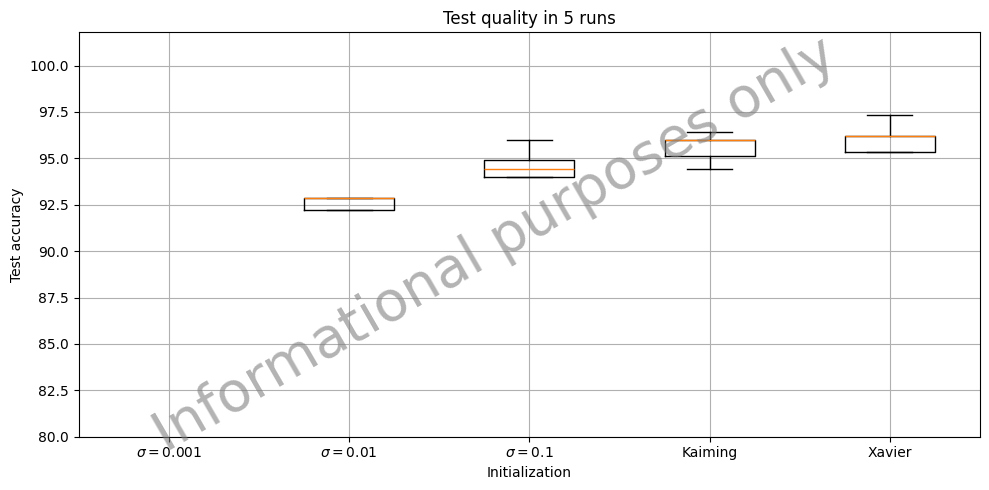

In [100]:
init_vars_for_plot = [
    (x if isinstance(x, str) else rf"$\sigma = {x}$") for x in init_vars
]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_ylim(80)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.text(
    0.5,
    0.5,
    "Informational purposes only",
    fontsize=40,
    color="gray",
    alpha=0.6,
    ha="center",
    va="center",
    rotation=30,
)

fig.tight_layout()
plt.show()


Give a detailed answer to the questions (in the same cell):
* How do the accuracy and stability of the training process differ with different initializations?
* Which initializations help train deeper networks?

__Answers:__

Kaiming and Xavier are consistently better or equal to normal initializations and don't require tuning $\sigma$.

Now let's compare the training speed for different initializations. Create two lists of lists `accs_test_on_iterations`, `accs_train_on_iterations`. The position `[i]` of each list (see description of `i` in the previous paragraph) should store a list of `accuracy` values on the test and training samples, respectively, obtained in model training time. Set the number of layers in the network to 4.

In [104]:
init_vars = [1e-3, 1e-2, 1e-1, "Kaiming", "Xavier"]


In [105]:
accs_test_on_iterations = [[] for _ in range(5)]
accs_train_on_iterations = [[] for _ in range(5)]

for i in range(5):
    dense_network = DenseNetwork(
        in_features=in_features,
        hidden_size=hidden_size,
        n_classes=n_classes,
        n_layers=4,
        activation=ReLU,
    )
    dense_network.apply(partial(initialize_module, init=init_vars[i]))
    optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
    loss_fn = CrossEntropyLoss()

    train_losses, test_losses, train_accs, test_accs = training_loop(
        n_epochs=200,
        network=dense_network,
        loss_fn=loss_fn,
        optimizer=optimizer,
        ds_train=(X_train, y_train),
        ds_test=(X_test, y_test),
        device=device,
    )
    accs_train_on_iterations[i] = train_accs
    accs_test_on_iterations[i] = test_accs


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.302/2.310. Accuracy, % (Train/Test): 10.76/8.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 10.76/8.22
Loss (Train/Test): 2.124/2.134. Accuracy, % (Train/Test): 26.50/26.00
Loss (Train/Test): 0.887/0.842. Accuracy, % (Train/Test): 70.45/70.67
Loss (Train/Test): 0.174/0.272. Accuracy, % (Train/Test): 94.14/92.89
Loss (Train/Test): 0.013/0.569. Accuracy, % (Train/Test): 99.85/95.56
Loss (Train/Test): 0.000/2.691. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/4.835. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/4.835. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/4.835. Accuracy, % (Train/Test): 100.00/94.67
Loss (Train/Test): 0.000/4.835. Accuracy, % (Train/Test): 100.00/94.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.415/2.442. Accuracy, % (Train/Test): 16.48/14.44
Loss (Train/Test): 0.372/0.383. Accuracy, % (Train/Test): 87.75/86.22
Loss (Train/Test): 0.026/0.210. Accuracy, % (Train/Test): 99.41/95.78
Loss (Train/Test): 0.000/1.460. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/2.449. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/2.449. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/2.449. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/2.449. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/2.449. Accuracy, % (Train/Test): 100.00/96.67
Loss (Train/Test): 0.000/2.449. Accuracy, % (Train/Test): 100.00/96.67


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 30.574/28.305. Accuracy, % (Train/Test): 5.64/6.00
Loss (Train/Test): 0.900/0.967. Accuracy, % (Train/Test): 69.34/69.78
Loss (Train/Test): 0.131/0.242. Accuracy, % (Train/Test): 96.14/94.00
Loss (Train/Test): 0.003/0.180. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/0.348. Accuracy, % (Train/Test): 100.00/98.00
Loss (Train/Test): 0.000/0.489. Accuracy, % (Train/Test): 100.00/97.78
Loss (Train/Test): 0.000/0.489. Accuracy, % (Train/Test): 100.00/97.78
Loss (Train/Test): 0.000/0.489. Accuracy, % (Train/Test): 100.00/97.78
Loss (Train/Test): 0.000/0.489. Accuracy, % (Train/Test): 100.00/97.78
Loss (Train/Test): 0.000/0.489. Accuracy, % (Train/Test): 100.00/97.78


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 4.943/4.698. Accuracy, % (Train/Test): 11.28/8.00
Loss (Train/Test): 0.254/0.305. Accuracy, % (Train/Test): 91.54/89.33
Loss (Train/Test): 0.033/0.221. Accuracy, % (Train/Test): 99.41/95.11
Loss (Train/Test): 0.000/0.677. Accuracy, % (Train/Test): 100.00/94.00
Loss (Train/Test): 0.000/2.069. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.069. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.069. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.069. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.069. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/2.069. Accuracy, % (Train/Test): 100.00/94.89


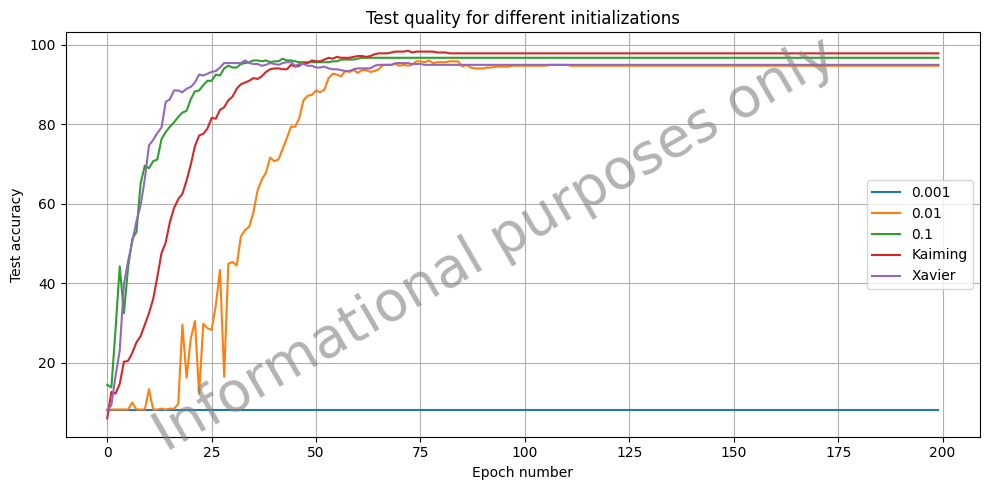

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for idx, label in enumerate(init_vars):
    ax.plot(accs_test_on_iterations[idx], label=label)

ax.set_title("Test quality for different initializations")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Test accuracy")
ax.grid(True)
ax.legend()

fig.text(
    0.5,
    0.5,
    "Informational purposes only",
    fontsize=40,
    color="gray",
    alpha=0.6,
    ha="center",
    va="center",
    rotation=30,
)

fig.tight_layout()
plt.show()


Give a detailed answer to the questions (in the same cell):
* How does the training speed change depending on the initialization chosen?

__Answers:__

Xavier and normal with the right $\sigma$ are faster in the beginning, though Kaiming achieves better results in the end.

## Experiments with different activation functions. [2 pts]

Let us now check which activation function help the neural network to train better.

At this point, you are to try training several neural networks with different activation functions.

To do this, we need to implement another $2$ layers: for the activation functions `Tanh` and `Sigmoid`.

In [107]:
class Tanh(torch.nn.Module):
    def __init__(self):
        """
        tanh(y) = (e^y - e^(-y)) / (e^y + e^(-y))
        Use the torch.tanh function to calculate the hyperbolic tangent.
        You can implement it yourself but then you will need to compute in a numerically stable way.
        """
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply Tanh elementwise
        """
        return torch.tanh(x)

    def __repr__(self):
        return "Tanh()"


In [108]:
class Sigmoid(torch.nn.Module):
    def __init__(self):
        """
        sigmoid(y) = 1 / (1 + e^(-y))
        Use the torch.special.expit function to calculate the sigmoid.
        You can implement it yourself but then you will need to compute in a numerically stable way.
        """
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply Sigmoid elementwise
        """
        return torch.sigmoid(x)

    def __repr__(self):
        return "Sigmoid()"


Now try training the neural network several times for each of the 3 activation functions. Fix the number of layers equal to $3$. In the case of `Tanh` and `Sigmoid` use the `Xavier` initialization, and in the case of `ReLU` use the `Kaiming` initialization.

Fill in the `accs_train` and `accs_test` matrices. Position `[i, j]` should contain the accuracy value of the network at the $j$-th run (all runs are identical) with the activation function $ReLU$ for $i = 0$, with the activation function $Tanh$ for $i = 1$ and with the activation function $Sigmoid$ for $i = 2$.

In [109]:
act_func_vars = ["ReLU", "Tanh", "Sigmoid"]
init_for_act_funcs = ["Kaiming", "Xavier", "Xavier"]


In [110]:
accs_train = np.zeros((3, 5))
accs_test = np.zeros((3, 5))


In [111]:
for i in range(3):
    for j in range(5):
        dense_network = DenseNetwork(
            in_features=in_features,
            hidden_size=hidden_size,
            n_classes=n_classes,
            n_layers=3,
            activation=eval(act_func_vars[i]),
        )
        dense_network.apply(partial(initialize_module, init=init_for_act_funcs[i]))
        optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()

        train_losses, test_losses, train_accs, test_accs = training_loop(
            n_epochs=200,
            network=dense_network,
            loss_fn=loss_fn,
            optimizer=optimizer,
            ds_train=(X_train, y_train),
            ds_test=(X_test, y_test),
            device=device,
        )
        accs_train[i, j] = train_accs[-1]
        accs_test[i, j] = test_accs[-1]


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 19.859/18.154. Accuracy, % (Train/Test): 15.96/18.89
Loss (Train/Test): 0.177/0.414. Accuracy, % (Train/Test): 93.69/88.89
Loss (Train/Test): 0.001/0.306. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/0.671. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.721. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.721. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.721. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.721. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.721. Accuracy, % (Train/Test): 100.00/95.33
Loss (Train/Test): 0.000/0.721. Accuracy, % (Train/Test): 100.00/95.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 34.371/34.431. Accuracy, % (Train/Test): 8.24/7.56
Loss (Train/Test): 0.230/0.376. Accuracy, % (Train/Test): 92.80/90.44
Loss (Train/Test): 0.004/0.317. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.541. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.678. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.678. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.678. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.678. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.678. Accuracy, % (Train/Test): 100.00/96.22
Loss (Train/Test): 0.000/0.678. Accuracy, % (Train/Test): 100.00/96.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 24.014/25.170. Accuracy, % (Train/Test): 10.10/8.00
Loss (Train/Test): 0.157/0.264. Accuracy, % (Train/Test): 95.47/92.89
Loss (Train/Test): 0.002/0.177. Accuracy, % (Train/Test): 100.00/95.78
Loss (Train/Test): 0.000/0.307. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.336. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.336. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.336. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.336. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.336. Accuracy, % (Train/Test): 100.00/96.44
Loss (Train/Test): 0.000/0.336. Accuracy, % (Train/Test): 100.00/96.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 33.272/32.485. Accuracy, % (Train/Test): 17.37/14.22
Loss (Train/Test): 0.287/0.349. Accuracy, % (Train/Test): 92.28/89.11
Loss (Train/Test): 0.005/0.162. Accuracy, % (Train/Test): 99.93/96.67
Loss (Train/Test): 0.000/0.363. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.465. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.465. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.465. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.465. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.465. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.465. Accuracy, % (Train/Test): 100.00/96.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 43.775/45.460. Accuracy, % (Train/Test): 10.39/10.00
Loss (Train/Test): 0.316/0.416. Accuracy, % (Train/Test): 89.76/87.56
Loss (Train/Test): 0.013/0.205. Accuracy, % (Train/Test): 99.78/95.78
Loss (Train/Test): 0.000/0.442. Accuracy, % (Train/Test): 100.00/97.11
Loss (Train/Test): 0.000/0.642. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.642. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.642. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.642. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.642. Accuracy, % (Train/Test): 100.00/96.89
Loss (Train/Test): 0.000/0.642. Accuracy, % (Train/Test): 100.00/96.89


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.493/2.499. Accuracy, % (Train/Test): 11.51/12.22
Loss (Train/Test): 0.179/0.263. Accuracy, % (Train/Test): 95.69/91.33
Loss (Train/Test): 0.056/0.205. Accuracy, % (Train/Test): 98.89/93.33
Loss (Train/Test): 0.014/0.256. Accuracy, % (Train/Test): 99.70/94.89
Loss (Train/Test): 0.634/1.122. Accuracy, % (Train/Test): 89.61/88.89
Loss (Train/Test): 295.197/285.464. Accuracy, % (Train/Test): 13.36/17.56
Loss (Train/Test): 3234939.500/3112379.250. Accuracy, % (Train/Test): 14.48/13.56
Loss (Train/Test): 1641843.750/1571644.000. Accuracy, % (Train/Test): 9.95/12.22
Loss (Train/Test): 731290.250/734344.562. Accuracy, % (Train/Test): 12.47/10.44
Loss (Train/Test): 20132116.000/19218360.000. Accuracy, % (Train/Test): 12.40/12.00


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.516/2.503. Accuracy, % (Train/Test): 10.99/9.33
Loss (Train/Test): 0.114/0.172. Accuracy, % (Train/Test): 96.96/93.78
Loss (Train/Test): 0.019/0.248. Accuracy, % (Train/Test): 99.63/94.00
Loss (Train/Test): 0.005/0.391. Accuracy, % (Train/Test): 99.78/94.67
Loss (Train/Test): 0.002/0.568. Accuracy, % (Train/Test): 99.85/94.67
Loss (Train/Test): 0.002/0.724. Accuracy, % (Train/Test): 99.85/94.22
Loss (Train/Test): 0.002/0.836. Accuracy, % (Train/Test): 99.85/94.44
Loss (Train/Test): 40.890/41.548. Accuracy, % (Train/Test): 0.00/0.00
Loss (Train/Test): 61229044.000/60721584.000. Accuracy, % (Train/Test): 17.82/18.22
Loss (Train/Test): 86207536.000/84507592.000. Accuracy, % (Train/Test): 11.80/11.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.532/2.441. Accuracy, % (Train/Test): 12.77/15.11
Loss (Train/Test): 0.157/0.186. Accuracy, % (Train/Test): 95.03/93.78
Loss (Train/Test): 0.033/0.223. Accuracy, % (Train/Test): 99.33/94.44
Loss (Train/Test): 0.008/0.387. Accuracy, % (Train/Test): 99.93/94.00
Loss (Train/Test): 0.003/0.477. Accuracy, % (Train/Test): 99.93/94.00
Loss (Train/Test): 0.001/0.706. Accuracy, % (Train/Test): 99.93/93.11
Loss (Train/Test): 0.001/1.077. Accuracy, % (Train/Test): 99.93/92.44
Loss (Train/Test): 0.001/1.624. Accuracy, % (Train/Test): 99.93/92.00
Loss (Train/Test): 0.001/2.140. Accuracy, % (Train/Test): 99.93/91.56
Loss (Train/Test): 0.001/2.264. Accuracy, % (Train/Test): 99.93/91.56


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.471/2.458. Accuracy, % (Train/Test): 7.57/6.44
Loss (Train/Test): 0.149/0.161. Accuracy, % (Train/Test): 96.07/96.22
Loss (Train/Test): 0.056/0.255. Accuracy, % (Train/Test): 98.59/95.11
Loss (Train/Test): 0.006/0.273. Accuracy, % (Train/Test): 99.93/95.78
Loss (Train/Test): 0.000/0.438. Accuracy, % (Train/Test): 100.00/95.11
Loss (Train/Test): 0.000/0.871. Accuracy, % (Train/Test): 100.00/94.89
Loss (Train/Test): 0.000/1.259. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.330. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/1.330. Accuracy, % (Train/Test): 100.00/94.22
Loss (Train/Test): 0.000/1.330. Accuracy, % (Train/Test): 100.00/94.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.474/2.447. Accuracy, % (Train/Test): 9.50/13.78
Loss (Train/Test): 0.165/0.237. Accuracy, % (Train/Test): 95.25/93.33
Loss (Train/Test): 0.061/0.211. Accuracy, % (Train/Test): 98.14/94.89
Loss (Train/Test): 0.026/0.278. Accuracy, % (Train/Test): 99.48/94.67
Loss (Train/Test): 0.008/0.368. Accuracy, % (Train/Test): 99.78/94.44
Loss (Train/Test): 0.003/0.512. Accuracy, % (Train/Test): 99.93/94.22
Loss (Train/Test): 0.001/0.868. Accuracy, % (Train/Test): 99.93/94.00
Loss (Train/Test): 0.001/1.327. Accuracy, % (Train/Test): 99.93/93.56
Loss (Train/Test): 0.001/1.846. Accuracy, % (Train/Test): 99.93/93.33
Loss (Train/Test): 0.001/2.224. Accuracy, % (Train/Test): 99.93/93.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.394/2.334. Accuracy, % (Train/Test): 9.13/13.11
Loss (Train/Test): 0.395/0.447. Accuracy, % (Train/Test): 87.16/86.00
Loss (Train/Test): 0.120/0.296. Accuracy, % (Train/Test): 96.88/92.22
Loss (Train/Test): 0.052/0.368. Accuracy, % (Train/Test): 98.22/93.33
Loss (Train/Test): 0.026/0.586. Accuracy, % (Train/Test): 99.11/92.44
Loss (Train/Test): 0.018/0.916. Accuracy, % (Train/Test): 99.26/91.56
Loss (Train/Test): 0.013/1.247. Accuracy, % (Train/Test): 99.55/92.44
Loss (Train/Test): 0.016/1.537. Accuracy, % (Train/Test): 99.48/93.11
Loss (Train/Test): 0.012/1.335. Accuracy, % (Train/Test): 99.55/93.11
Loss (Train/Test): 0.010/1.635. Accuracy, % (Train/Test): 99.55/93.33


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.378/2.355. Accuracy, % (Train/Test): 9.06/13.33
Loss (Train/Test): 0.398/0.453. Accuracy, % (Train/Test): 87.53/84.89
Loss (Train/Test): 0.136/0.301. Accuracy, % (Train/Test): 95.84/92.22
Loss (Train/Test): 0.066/0.422. Accuracy, % (Train/Test): 98.07/92.44
Loss (Train/Test): 0.040/0.744. Accuracy, % (Train/Test): 98.59/90.89
Loss (Train/Test): 0.031/0.851. Accuracy, % (Train/Test): 99.11/91.33
Loss (Train/Test): 0.022/0.954. Accuracy, % (Train/Test): 99.26/92.00
Loss (Train/Test): 0.017/1.469. Accuracy, % (Train/Test): 99.41/91.11
Loss (Train/Test): 0.016/2.365. Accuracy, % (Train/Test): 99.41/90.89
Loss (Train/Test): 0.015/3.103. Accuracy, % (Train/Test): 99.41/91.11


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.383/2.436. Accuracy, % (Train/Test): 9.58/9.56
Loss (Train/Test): 0.333/0.344. Accuracy, % (Train/Test): 89.83/89.78
Loss (Train/Test): 0.083/0.295. Accuracy, % (Train/Test): 97.70/93.56
Loss (Train/Test): 0.017/0.517. Accuracy, % (Train/Test): 99.55/94.67
Loss (Train/Test): 0.005/0.961. Accuracy, % (Train/Test): 99.85/93.56
Loss (Train/Test): 0.003/2.045. Accuracy, % (Train/Test): 99.85/92.22
Loss (Train/Test): 0.003/2.924. Accuracy, % (Train/Test): 99.85/91.78
Loss (Train/Test): 403.558/1027.124. Accuracy, % (Train/Test): 89.46/84.22
Loss (Train/Test): 3181086.000/3705677.250. Accuracy, % (Train/Test): 68.45/66.89
Loss (Train/Test): 14661114880.000/14595365888.000. Accuracy, % (Train/Test): 0.67/0.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.487/2.407. Accuracy, % (Train/Test): 9.35/12.22
Loss (Train/Test): 0.381/0.434. Accuracy, % (Train/Test): 89.16/88.44
Loss (Train/Test): 2.885/2.899. Accuracy, % (Train/Test): 61.92/60.67
Loss (Train/Test): 0.070/0.443. Accuracy, % (Train/Test): 97.85/91.33
Loss (Train/Test): 0.037/0.604. Accuracy, % (Train/Test): 98.66/91.56
Loss (Train/Test): 0.018/0.870. Accuracy, % (Train/Test): 99.48/90.67
Loss (Train/Test): 0.010/1.407. Accuracy, % (Train/Test): 99.70/91.33
Loss (Train/Test): 0.011/2.472. Accuracy, % (Train/Test): 99.63/90.44
Loss (Train/Test): 0.006/3.652. Accuracy, % (Train/Test): 99.70/90.67
Loss (Train/Test): 305.809/340.378. Accuracy, % (Train/Test): 38.83/36.22


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.443/2.458. Accuracy, % (Train/Test): 8.61/11.56
Loss (Train/Test): 0.279/0.353. Accuracy, % (Train/Test): 90.72/89.56
Loss (Train/Test): 0.096/0.304. Accuracy, % (Train/Test): 96.81/93.56
Loss (Train/Test): 0.048/0.322. Accuracy, % (Train/Test): 98.66/94.89
Loss (Train/Test): 0.410/0.819. Accuracy, % (Train/Test): 93.24/91.78
Loss (Train/Test): 4.580/5.042. Accuracy, % (Train/Test): 64.07/60.44
Loss (Train/Test): 1.034/1.299. Accuracy, % (Train/Test): 73.42/69.56
Loss (Train/Test): 0.346/0.589. Accuracy, % (Train/Test): 90.20/86.67
Loss (Train/Test): 0.242/0.496. Accuracy, % (Train/Test): 92.95/87.56
Loss (Train/Test): 0.177/0.548. Accuracy, % (Train/Test): 93.62/86.89


Draw the boxplots of the obtained accuracy (the horizontal line in each column is the average, the rectangle shows the spread).

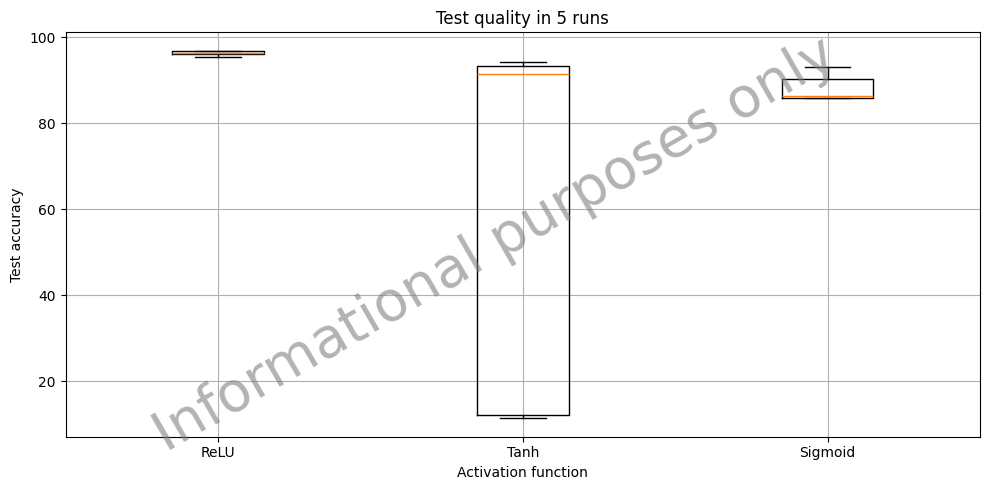

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, tick_labels=act_func_vars, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Activation function")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.text(
    0.5,
    0.5,
    "Informational purposes only",
    fontsize=40,
    color="gray",
    alpha=0.6,
    ha="center",
    va="center",
    rotation=30,
)

fig.tight_layout()
plt.show()


Give a detailed answer to the questions (in the same cell):
* How do the accuracy and stability of the training process differ for different activation functions?

__Answers:__

As expected, ReLU works better on average and with less variance. And median test performance for Tanh is better than for Sigmoid.